## Quantum amplitude estimation with error mitigation for time\-evolving probabilistic networks

- in this notebook, we consider the discrete time evolution of probabilistic network models and low\-depth quantum amplitude estimation techniques
- see M.C. Braun, T. Decker, N. Hegemann, S.F. Kerstan, C. Maier, J. Ulmanis: Quantum amplitude estimation with error mitigation for time\-evolving probabilistic networks  
- functions for the network models are in module <span style='font-family:courier'>pygrnd.qc.probabilisticNetworks</span>
- functions for gradient descent for low\-depth QAE \(with and without error model\) are in module <span style='font-family:courier'>pygrnd.qc.lowDepthQAEgradientDescent</span>
- the results from the simulations and optimizations might be different for each execution of the code



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pygrnd.qc.probabilisticNetworks import *
from pygrnd.qc.parallelQAE import constructGroverOperator, circuitStandardQAE, bit2prob, maxString
from pygrnd.qc.lowDepthQAEgradientDescent import *
from pygrnd.qc.helper import counts2probs
from qiskit.visualization import plot_histogram
from qiskit import transpile
from qiskit.circuit.library.standard_gates import ZGate

jos_palette = ['#4c32ff', '#b332ff', '#61FBF8', '#1E164F', '#c71ab1ff']
sns.set_palette(jos_palette)
matplotlib.rcParams.update({'font.size': 18})

#### Example of a probabilistic network model with 2 nodes

- each of the 2 nodes has probabilities for intrinsic failure and recovery in a time step
- a failed node can trigger the failure of another node in the next time step with the given probability
- the probabilities for triggering another node can be seen as the weigths of edges in the dependency graph of the nodes
- we are interested in the probabilities of the configurations 00, 01, 10 and 11 after 3 time steps following the initialization  



In [2]:
nodes=['n1','n2']
probFail={'n1':0.2,'n2':0.7}
probRecovery={'n1':0.3,'n2':0.8}
edges={('n1','n2'):0.2,('n2','n1'):0.8}

#### Classical and Monte Carlo evaluation

- the evaluation function <span style='font-family:courier'>classicalEvaluation</span> of Pygrnd calculates the probabilities exactly  
- the function calculates the probability for all $2^k$ possible configurations in each time step when we have $k$ nodes
- the function returns a list of the probabilities of all possible configurations



In [3]:
timesteps=3
resultClassical=classicalEvaluation(timesteps, nodes, probFail, probRecovery, edges)
print(resultClassical)

[0.1399616, 0.21922239999999996, 0.3080864, 0.33272959999999996]


- the Monte Carlo evaluation function <span style='font-family:courier'>monteCarloEvaluation</span> of Pygrnd simulates the configuration in each time step 
- the default setting of the function is 100000 rounds
- the function returns a list of the approximated probabilities of all possible configurations  



In [4]:
timesteps=3
resultMonteCarlo=monteCarloEvaluation(timesteps, nodes, probFail, probRecovery, edges, rounds=100000)
print(resultMonteCarlo)

[0.14103, 0.21815, 0.30775, 0.33307]


- we compare the exact evaluation with the results of 20 Monte Carlo simulations
- we run Monte Carlo simulations with 1000, 10000, 100000 and 1000000 rounds  
- we visualize the deviations of the Monte Carlo results from the exact value depending on the number of rounds



In [5]:
xe=[]   # store the number of Monte Carlo rounds
ye00=[] # results for configuration 00
ye01=[] # results for configuration 01
ye10=[] # results for configuration 10
ye11=[] # results for configuration 11

for re in [3, 4, 5, 6]:
    r=10**re
    for i in range(20):
        mc=monteCarloEvaluation(timesteps, nodes, probFail, probRecovery, edges, rounds=r)
        xe.append(re)
        ye00.append(mc[0])
        ye01.append(mc[1])
        ye10.append(mc[2])
        ye11.append(mc[3])

In [6]:
matplotlib.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(2,2,figsize=(20,10))
ax[0,0].set_xscale("log")
ax[0,1].set_xscale("log")
ax[1,0].set_xscale("log")
ax[1,1].set_xscale("log")

ax[0,0].scatter([10**x for x in xe],ye00,color=jos_palette[3],label='$p_{00}(3)$')
ax[1,0].scatter([10**x for x in xe],ye10,color=jos_palette[3],label='$p_{01}(3)$')
ax[0,1].scatter([10**x for x in xe],ye01,color=jos_palette[3],label='$p_{10}(3)$')
ax[1,1].scatter([10**x for x in xe],ye11,color=jos_palette[3],label='$p_{11}(3)$')


ax[0,0].hlines(y=resultClassical[0], xmin=10**3, xmax=10**6, linewidth=1,colors=jos_palette[3],label='exact probability '+str(round(resultClassical[0],3)))
ax[1,0].hlines(y=resultClassical[2], xmin=10**3, xmax=10**6, linewidth=1,colors=jos_palette[3],label='exact probability '+str(round(resultClassical[2],3)))
ax[0,1].hlines(y=resultClassical[1], xmin=10**3, xmax=10**6, linewidth=1,colors=jos_palette[3],label='exact probability '+str(round(resultClassical[1],3)))
ax[1,1].hlines(y=resultClassical[3], xmin=10**3, xmax=10**6, linewidth=1,colors=jos_palette[3],label='exact probability '+str(round(resultClassical[3],3)))

ax[0,0].set(xlabel='number of Monte Carlo samples',ylabel='probability')
ax[0,1].set(xlabel='number of Monte Carlo samples',ylabel='probability')
ax[1,0].set(xlabel='number of Monte Carlo samples',ylabel='probability')
ax[1,1].set(xlabel='number of Monte Carlo samples',ylabel='probability')
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

- we additionally compare the results for time steps 1 to 4 and all configurations  
- we compare the exact value with the results of 20 Monte Carlo simulations with 10000 rounds each



In [7]:
#
# Calculate the exact values for the configurations 00, 01, 10 and 11 for all time steps from 1 to 4
#
xe2=[]
ye2_00=[]
ye2_01=[]
ye2_10=[]
ye2_11=[]
for t in range(1,5):
    vc=classicalEvaluation(t, nodes, probFail, probRecovery, edges)
    xe2.append(t)
    ye2_00.append(vc[0])
    ye2_01.append(vc[1])
    ye2_10.append(vc[2])
    ye2_11.append(vc[3])

In [8]:
#
# Calculate the results of 20 Monte Carlo runs for the configurations 00, 01, 10 and 11 for time steps 1 to 4.
#
xe=[]
ye00=[]
ye01=[]
ye10=[]
ye11=[]
for t in range(1,5):
    for i in range(20):
        mc=monteCarloEvaluation(t, nodes, probFail, probRecovery, edges, rounds=10000)
        xe.append(t)
        ye00.append(mc[0])
        ye01.append(mc[1])
        ye10.append(mc[2])
        ye11.append(mc[3])

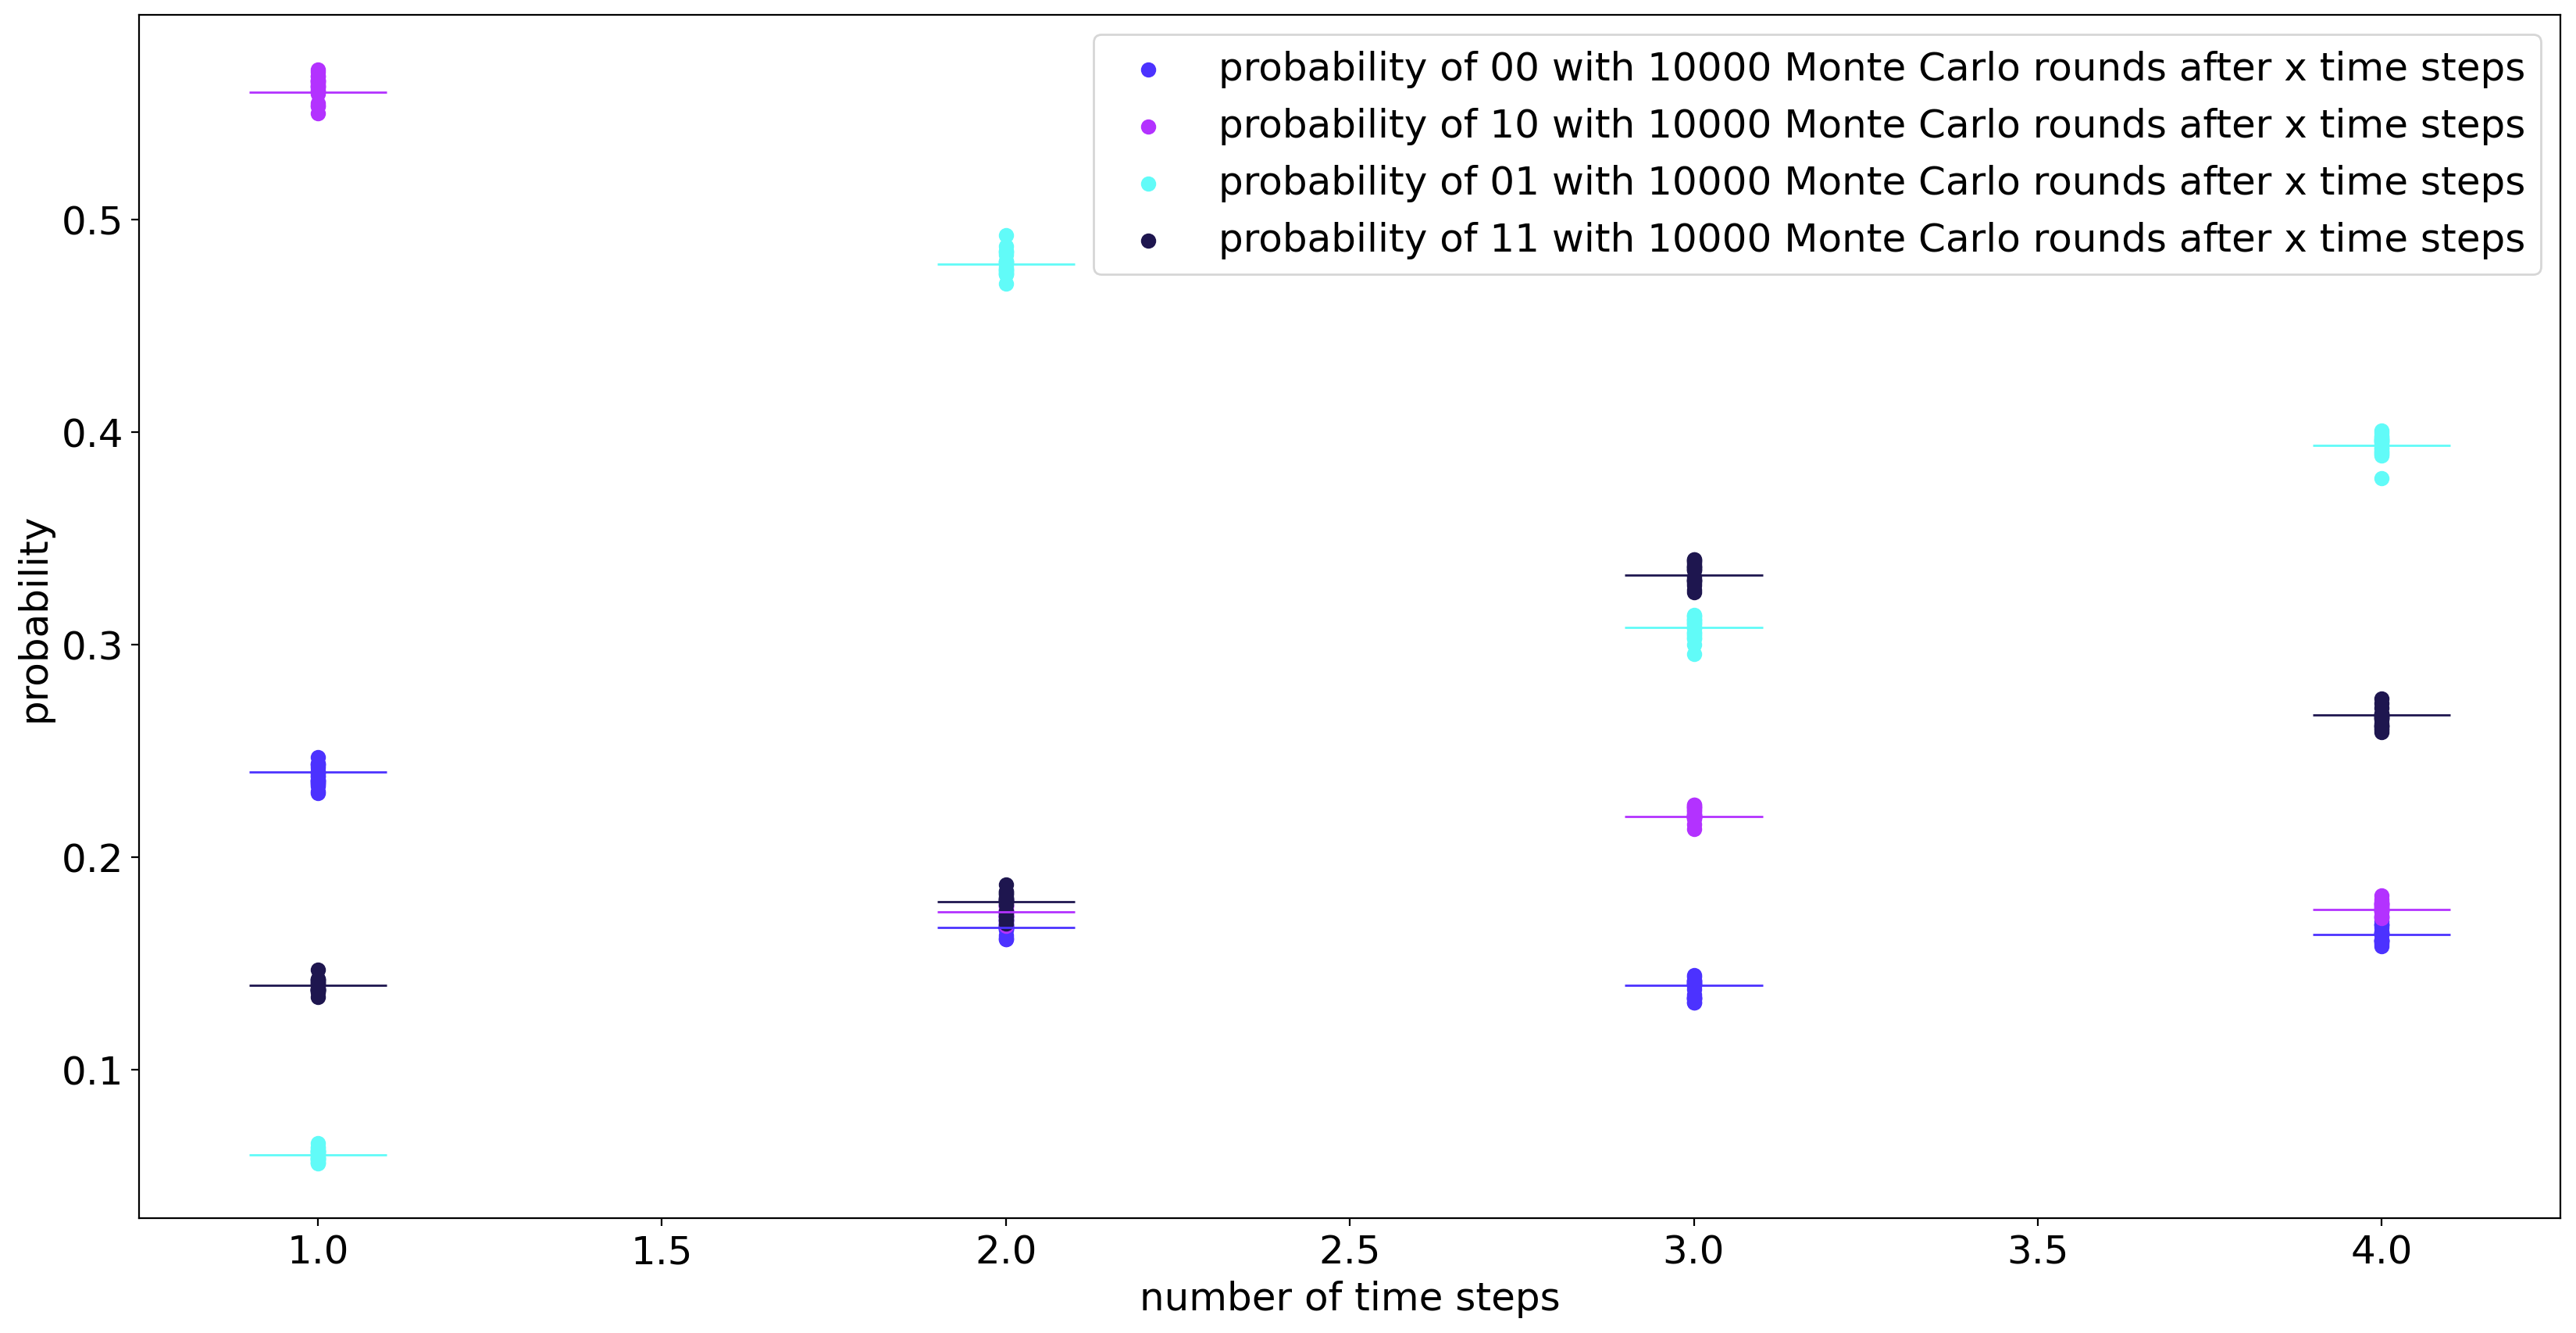

In [9]:
matplotlib.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(figsize=(20,10))

ax.scatter(xe,ye00,label='probability of 00 with 10000 Monte Carlo rounds after x time steps')
ax.scatter(xe,ye01,label='probability of 10 with 10000 Monte Carlo rounds after x time steps')
ax.scatter(xe,ye10,label='probability of 01 with 10000 Monte Carlo rounds after x time steps')
ax.scatter(xe,ye11,label='probability of 11 with 10000 Monte Carlo rounds after x time steps')

for t in range(4):
    ax.hlines(y=ye2_00[t], xmin=t+1-0.1, xmax=t+1+0.1, linewidth=1,colors=jos_palette[0])
    ax.hlines(y=ye2_01[t], xmin=t+1-0.1, xmax=t+1+0.1, linewidth=1,colors=jos_palette[1])
    ax.hlines(y=ye2_10[t], xmin=t+1-0.1, xmax=t+1+0.1, linewidth=1,colors=jos_palette[2])
    ax.hlines(y=ye2_11[t], xmin=t+1-0.1, xmax=t+1+0.1, linewidth=1,colors=jos_palette[3])

ax.set(xlabel='number of time steps',ylabel='probability')
ax.legend()

#### Quantum circuits for probabilistic networks

- we create the quantum circuit for the model with 2 nodes and 3 time steps after the initialization
- we measure the last 2 qubits to get the probabilities of the configurations in the last time step
- the function <span style='font-family:courier'>createCircuit</span> of Pygrnd uses barriers to make the structure more visible
- the alternative function <span style='font-family:courier'>createCircuitNoBarrierNoClassicalBits</span> of Pygrnd does not add barriers and classical bits, this allows the circuit to be used as part of bigger circuits  



In [10]:
timesteps=3
qc,qr,cr=createCircuit(timesteps, nodes, probFail, probRecovery, edges)
qc.draw(output='mpl')

- we compare the result from the exact classical evaluation with an exact evaluation with the statevector simulator
- the function <span style='font-family:courier'>evaluateQuantum</span> of Pygrnd creates the quantum circuit and uses the statevector simulator to calculate the probabilities of the configurations  



In [11]:
resultQuantum=evaluateQuantum(timesteps, nodes, probFail, probRecovery, edges)

print("classical evaluation:",resultClassical)
print("quantum evaluation:",resultQuantum)

classical evaluation: [0.1399616, 0.21922239999999996, 0.3080864, 0.33272959999999996]
quantum evaluation: [0.1399616, 0.2192224, 0.3080864000000001, 0.33272960000000007]


- we measure the two qubits at the end and we compare the result of a measurement with the exact result
- we obtain results that are close to the exact values
- the deviation from the exact values comes from the restriction to 1000 repetitions in this example  



In [12]:
# Measure the last two qubits at the end and simulate the circuit with 1000 shots.
qc.measure(qr[4:],cr)
backend_qiskit = Aer.get_backend(name='qasm_simulator')
job = execute(qc, backend_qiskit,shots=1000)
c = job.result().get_counts()
probs={x:c[x]/sum(c.values()) for x in c}

exactValues={'00':resultQuantum[0], '10':resultQuantum[1], '01':resultQuantum[2], '11':resultQuantum[3]}

fig,axs=plt.subplots(1)
matplotlib.rcParams.update({'font.size': 18})
plot_histogram([exactValues,probs],legend=['exact','1000 repetitions'],color=['black','gray'],ax=axs)
axs.set(xlabel='result',ylabel='probability')
print(axs)

AxesSubplot(0.125,0.11;0.775x0.77)


#### Construction of Grover operators

- we construct 4 Grover operators, one operator for each of the target configurations 00, 01, 10, 11 in the last time step
- we use the function <span style='font-family:courier'>contructGroverOperator</span> from Pygrnd
- we mark all states that have the corresponding configuration in the last two qubits
- in this case, the function is not very efficient as there are many configurations matching the conditions
- as a more efficient alternative, we could add a phase operation to the last register only
- this alternative would avoid many operations that are controlled by several qubits
- for a simulator without noise the complexity of the construction of the Grover operators does not influence the results  



In [13]:
# Create the model gate.
qc=createCircuitNoBarrierNoClassicalBits(timesteps, nodes, probFail, probRecovery, edges)
model=qc.to_gate()

# Collect all bitstrings that correspond to the configuration in the last qubit.
targets00=['00'+s for s in allCombinations(2*timesteps-2)]
targets01=['01'+s for s in allCombinations(2*timesteps-2)]
targets10=['10'+s for s in allCombinations(2*timesteps-2)]
targets11=['11'+s for s in allCombinations(2*timesteps-2)]

# Generate the Grover operators for each configuration.
grover00=constructGroverOperator(model, targets00)
grover01=constructGroverOperator(model, targets01)
grover10=constructGroverOperator(model, targets10)
grover11=constructGroverOperator(model, targets11)

- we examine the non\-trivial eigenvalues for correctness
- each Grover operator has two non\-trivial eigenvalues and the two corresponding probabilies are the same  
- we compare the probabilities from the eigenvalues to the correct values of the probabilities



In [14]:
realValues=classicalEvaluation(timesteps, nodes, probFail, probRecovery, edges)
grovers=[grover00,grover10,grover01,grover11]

evalues=[]
probs=[]
for i in range(len(grovers)):
    grover=grovers[i]
    qr=QuantumRegister(2*timesteps,'q')
    qc=QuantumCircuit(qr)
    qc.append(grover,qr)
    backend_qiskit = Aer.get_backend(name='unitary_simulator')
    job = execute(qc, backend_qiskit)
    u=job.result().get_unitary()
    from numpy.linalg import eig
    eVal,eVec=eig(u)
    for e in eVal:
        if abs(e-1)>0.001 and abs(e+1)>0.001:
            print("i=",i," probability for this eigenvalue=",math.sin(np.angle(e)/2)**2,"(exact value="+str(realValues[i])+")")
            evalues.append(e)
            probs.append(math.sin(np.angle(e)/2)**2)

i= 0  probability for this eigenvalue= 0.13996159999999958 (exact value=0.1399616)
i= 0  probability for this eigenvalue= 0.1399616000000003 (exact value=0.1399616)


i= 1  probability for this eigenvalue= 0.2192223999999989 (exact value=0.21922239999999996)
i= 1  probability for this eigenvalue= 0.21922240000000076 (exact value=0.21922239999999996)


i= 2  probability for this eigenvalue= 0.3080863999999997 (exact value=0.3080864)
i= 2  probability for this eigenvalue= 0.3080864000000006 (exact value=0.3080864)


i= 3  probability for this eigenvalue= 0.33272959999999907 (exact value=0.33272959999999996)
i= 3  probability for this eigenvalue= 0.33272960000000135 (exact value=0.33272959999999996)


#### Standard quantum amplitude estimation for probabilistic networks

- we can construct the standard version of quantum amplitude estimation with the Pygrnd function <span style='font-family:courier'>circuitStandardQAE</span>  
- this construction needs controlled $G^{2^i}$ operators where $G$ is the Grover operator
- for a resolution of $b$ bits we need $1+2+2^2+\ldots+2^{b-1}$ controlled Grover operators
- for showing the structure of the circuits, we construct the circuit for a quantum amplitude estimation with a 3 bit resolution for the configuration 00 in time step 3



In [15]:
qc=circuitStandardQAE(model, grovers[0], precision=3)
qc.draw(output='mpl')

- we run a standard quantum amplitude estimation for each of the 4 configurations
- for each configuration, we run the amplitude estimation for 1 to 9 bits of resolution 
- for each experiment, we take the result with the highest count and convert it to the corresponding probability
- we see the convergence of the QAE results to the correct values
- we use functions <span style='font-family:courier'>maxString</span> and <span style='font-family:courier'>bit2prob</span> from the module <span style='font-family:courier'>pygrnd.qc.parallelQAE</span> to identify the result with highest count and to convert it to the corresponding probability value  



In [16]:
xe=[]   # store the number of bits for the precision
ye00=[] # store the probability that corresponds to the result with the highest number of counts
ye01=[]
ye10=[]
ye11=[]

pmax=10
backend_qiskit = Aer.get_backend(name='qasm_simulator')

for p in range(1,pmax):
    xe.append(p)

    i=0
    qc=circuitStandardQAE(model, grovers[i], precision=p)
    job = execute(qc, backend_qiskit,shots=100)
    c = job.result().get_counts()
    ye00.append(bit2prob(maxString(c)))

    i=1
    qc=circuitStandardQAE(model, grovers[i], precision=p)
    job = execute(qc, backend_qiskit,shots=100)
    c = job.result().get_counts()
    ye01.append(bit2prob(maxString(c)))

    i=2
    qc=circuitStandardQAE(model, grovers[i], precision=p)
    job = execute(qc, backend_qiskit,shots=100)
    c = job.result().get_counts()
    ye10.append(bit2prob(maxString(c)))

    i=3
    qc=circuitStandardQAE(model, grovers[i], precision=p)
    job = execute(qc, backend_qiskit,shots=100)
    c = job.result().get_counts()
    ye11.append(bit2prob(maxString(c)))

- we compare the exact values with the results from quantum amplitude estimation for different precisions  
- we see that with an increasing number of bits for the resolution the results get closer to the correct value



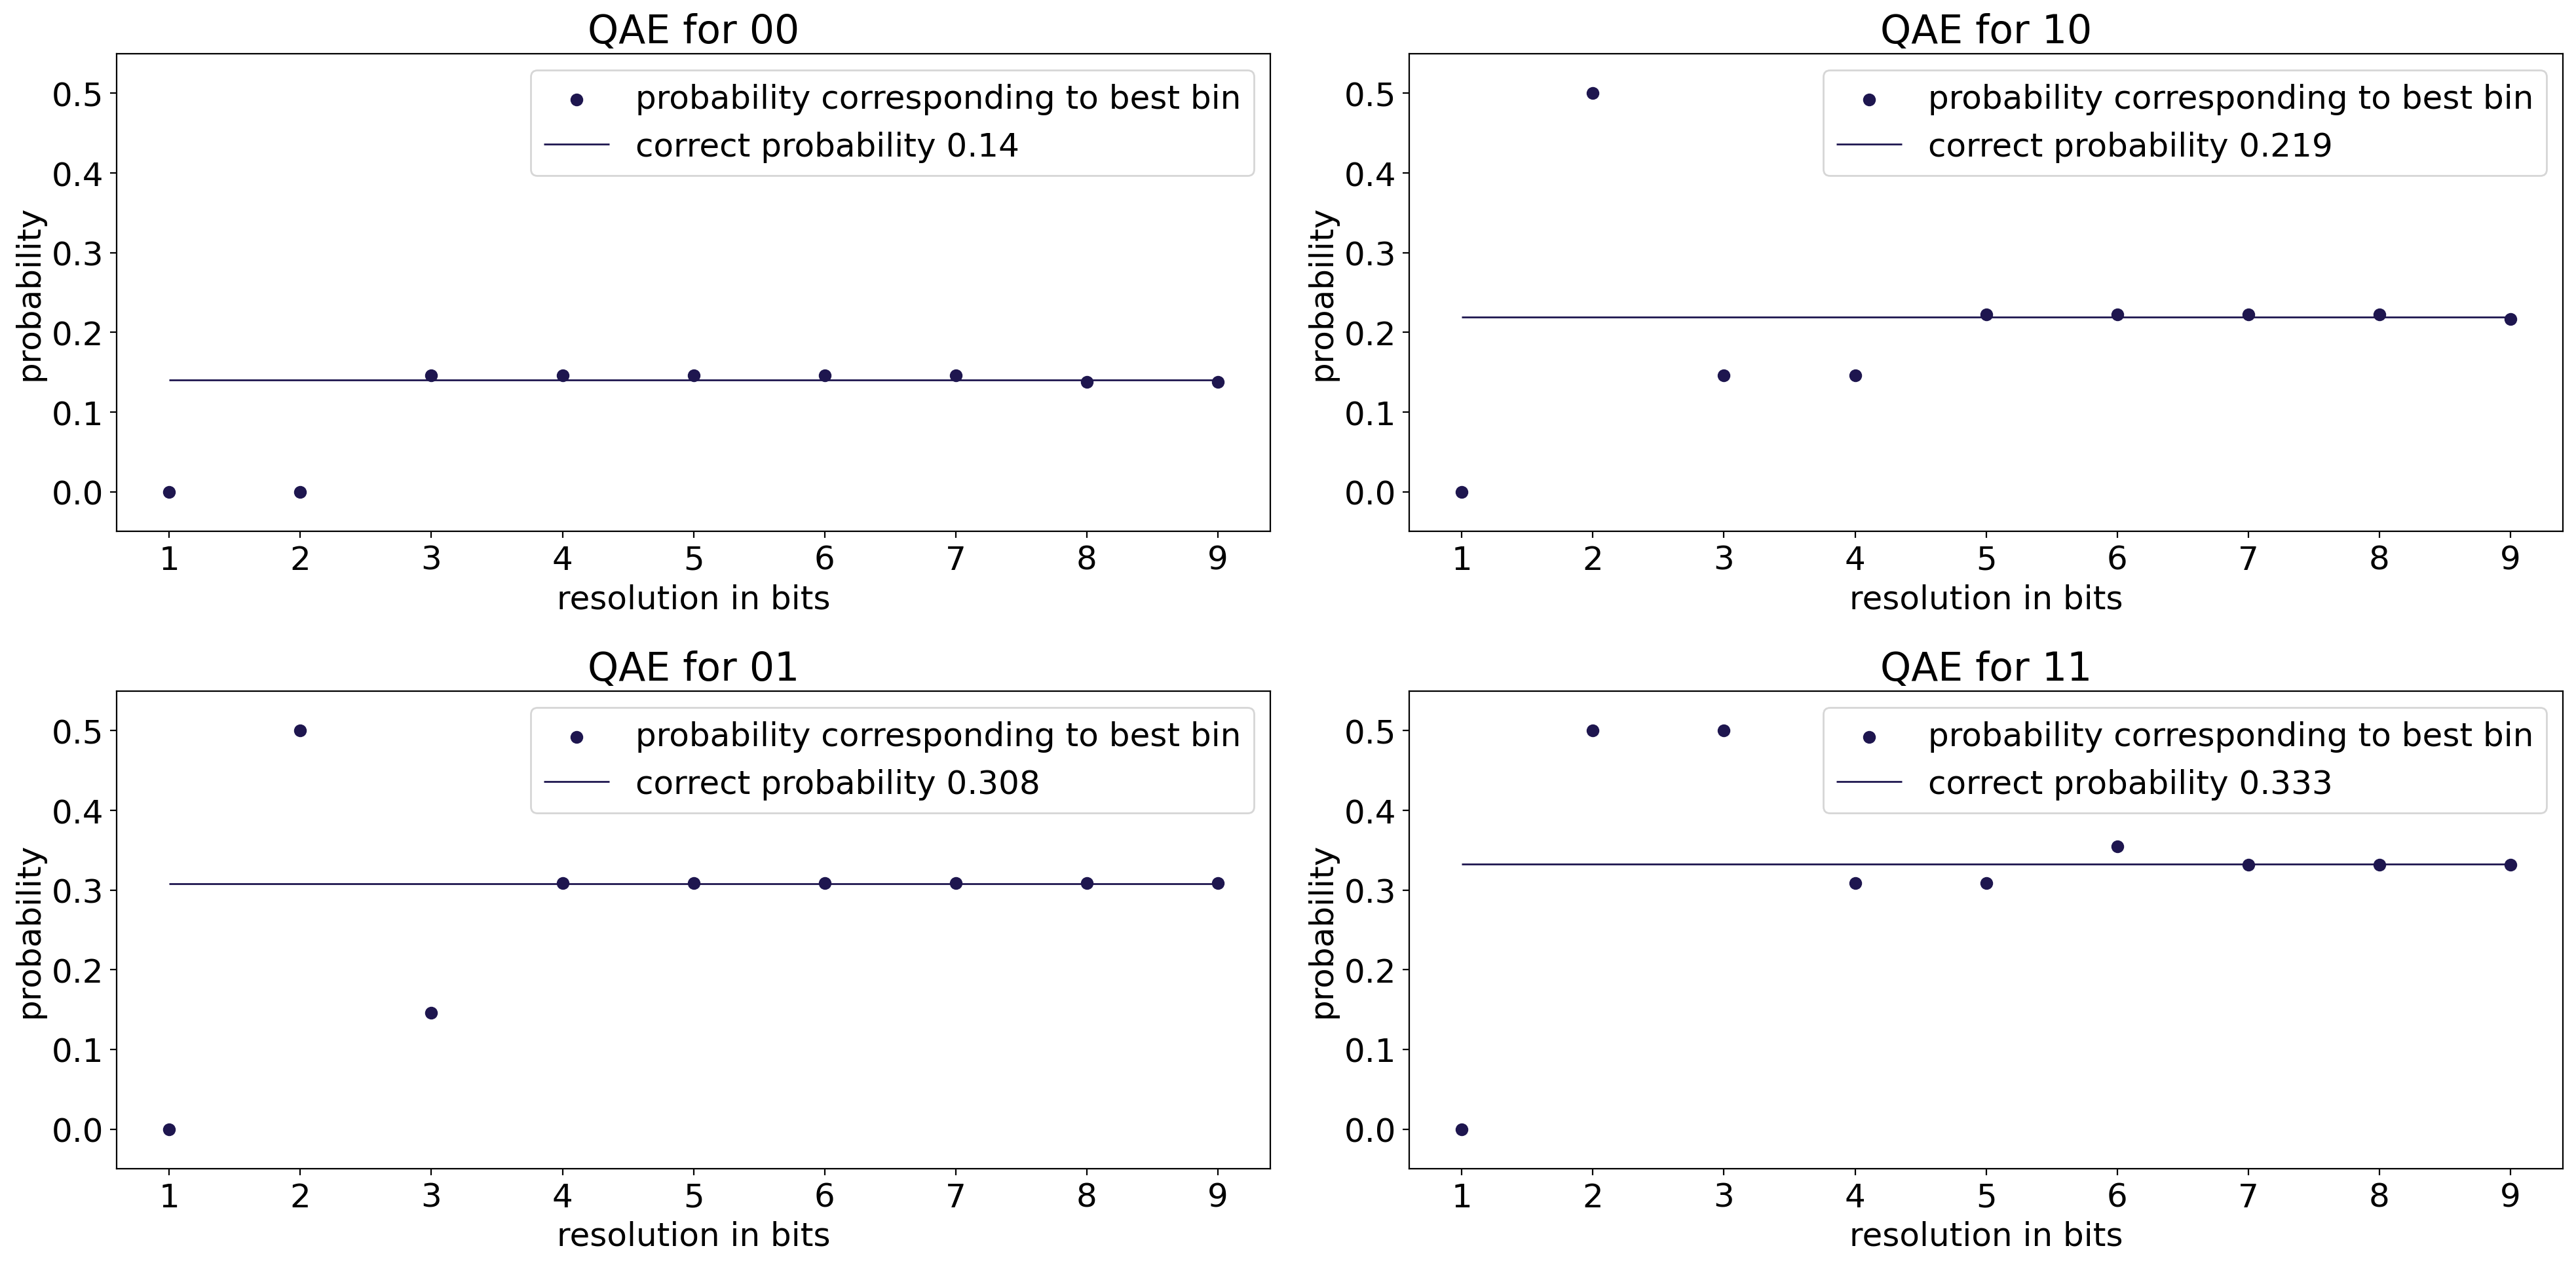

In [17]:
matplotlib.rcParams.update({'font.size': 18})
fig,axs=plt.subplots(2,2,figsize=(20,10))
axs[0,0].set_title('QAE for 00')
axs[0,1].set_title('QAE for 10')
axs[1,0].set_title('QAE for 01')
axs[1,1].set_title('QAE for 11')
for i in [0,1]:
    for j in [0,1]:
        axs[i,j].set_ylim([-0.05, 0.55])
        axs[i,j].set_xlabel("resolution in bits")
        axs[i,j].set_ylabel("probability")

axs[0,0].scatter(xe,ye00,label='probability corresponding to best bin',color=jos_palette[3])
axs[0,1].scatter(xe,ye01,label='probability corresponding to best bin',color=jos_palette[3])
axs[1,0].scatter(xe,ye10,label='probability corresponding to best bin',color=jos_palette[3])
axs[1,1].scatter(xe,ye11,label='probability corresponding to best bin',color=jos_palette[3])

axs[0,0].hlines(y=resultClassical[0], xmin=1, xmax=9, linewidth=1,colors=jos_palette[3],label='correct probability '+str(round(resultClassical[0],3)))
axs[0,1].hlines(y=resultClassical[1], xmin=1, xmax=9, linewidth=1,colors=jos_palette[3],label='correct probability '+str(round(resultClassical[1],3)))
axs[1,0].hlines(y=resultClassical[2], xmin=1, xmax=9, linewidth=1,colors=jos_palette[3],label='correct probability '+str(round(resultClassical[2],3)))
axs[1,1].hlines(y=resultClassical[3], xmin=1, xmax=9, linewidth=1,colors=jos_palette[3],label='correct probability '+str(round(resultClassical[3],3)))

axs[0,0].legend()
axs[0,1].legend()
axs[1,0].legend()
axs[1,1].legend()

fig.tight_layout()
plt.show()

#### Low-depth quantum amplitude estimation

- the standard version of the quantum amplitude estimation needs controlled Grover operators
- low\-depth versions do not need controlled Grover operators
- these versions also do not need additional qubits for the kickbacks and Fourier transforms
- this makes the circuits more viable for current hardware implementations of quantum computers
- we apply several Grover operators after the initialization with the model circuit
- the number of Grover operators and the post\-processing depends on the specific function of low\-depth amplitude estimations  
- we consider an example circuit for 3 Grover operations after the initialization step



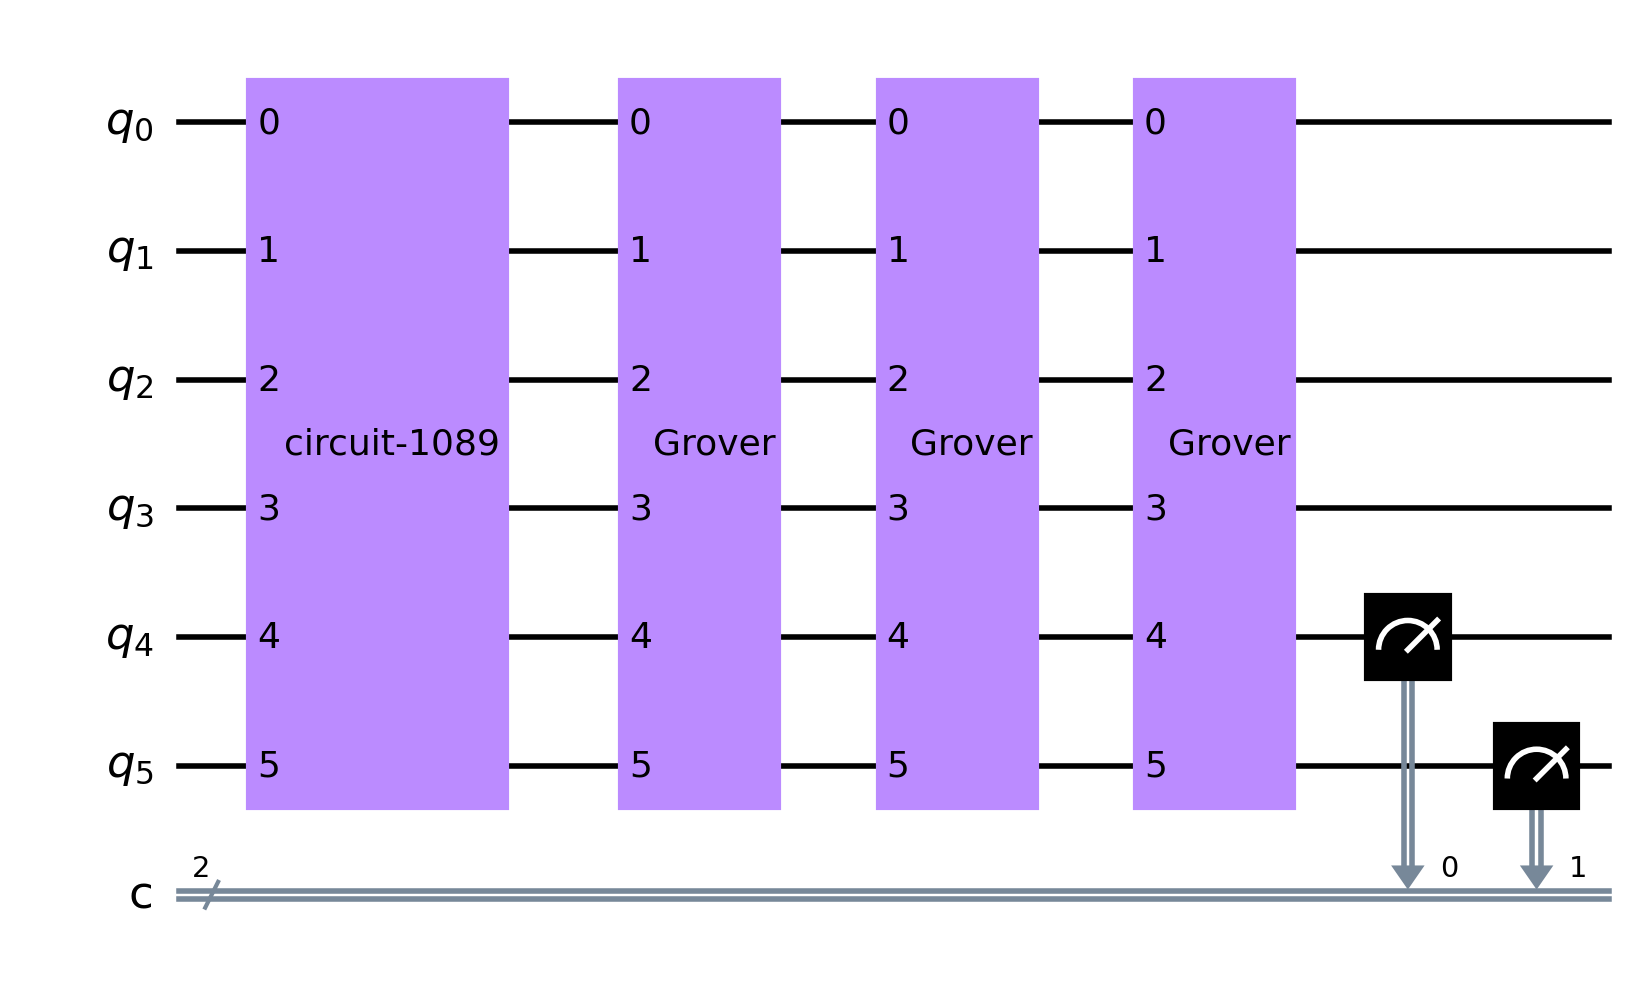

In [18]:
groverN=3
qr=QuantumRegister(6,'q')
cr=ClassicalRegister(2,'c')
qc=QuantumCircuit(qr,cr)
qc.append(model,qr)
for j in range(groverN):
    qc.append(grover,qr)
qc.measure(qr[4:],cr)
qc.draw(output='mpl')

- for each of the 4 target configurations, we run a low\-depth version of quantum amplitude estimation
- for simplification, we just consider circuits with 0 to 8 Grover operators after the initialization
- we run each circuit 30 times \(number of repetitions\) and we count how often the corresponding configuration can be found
- we use an error\-free simulator  



In [19]:
shots=30

N_buffer=[] # Total repetitions.
M_buffer=[] # Number Kickbacks.
R_buffer=[] # Good results.

targets=['00','10','01','11'] # Note that in Qiskit notation the least significant bit is at the bottom

for i in range(len(grovers)):
    grover=grovers[i]
    N=[]
    M=[]
    R=[]
    for groverN in [0,1,2,3,4,5,6,7,8]:
        qr=QuantumRegister(6,'q')
        cr=ClassicalRegister(2,'c')
        qc=QuantumCircuit(qr,cr)
        qc.append(model,qr)
        for j in range(groverN):
            qc.append(grover,qr)
        qc.measure(qr[4:],cr)
        backend_qiskit = Aer.get_backend(name='qasm_simulator')
        job = execute(qc, backend_qiskit,shots=shots)
        c = job.result().get_counts()
        N.append(shots)
        M.append(groverN)
        if targets[i] in c:
            R.append(c[targets[i]])
        else:
            R.append(0)
    print("count vector (0 to 8 Grover operators after model) of target config",targets[i],":",R)
    N_buffer.append(N)
    M_buffer.append(M)
    R_buffer.append(R)

count vector (0 to 8 Grover operators after model) of target config 00 : [4, 27, 24, 5, 4, 24, 30, 3, 3]


count vector (0 to 8 Grover operators after model) of target config 10 : [5, 28, 11, 1, 30, 19, 0, 22, 27]


count vector (0 to 8 Grover operators after model) of target config 01 : [10, 28, 1, 22, 17, 2, 26, 9, 14]


count vector (0 to 8 Grover operators after model) of target config 11 : [5, 28, 0, 26, 10, 6, 28, 0, 20]


- we generate reference data to compare the counts of the error\-free simulations with the expected values
- we generate the values for non\-integer values to make the function of the probability more visible  



In [20]:
n= 30 # shots
xe_t=[]
ye_t00=[]
ye_t01=[]
ye_t10=[]
ye_t11=[]
for i in range(90):
    xe_t.append(i/10)
    ye_t00.append(n*math.sin((1+2*i/10)*np.angle(evalues[0])/2)**2)
    ye_t01.append(n*math.sin((1+2*i/10)*np.angle(evalues[2])/2)**2)
    ye_t10.append(n*math.sin((1+2*i/10)*np.angle(evalues[4])/2)**2)
    ye_t11.append(n*math.sin((1+2*i/10)*np.angle(evalues[6])/2)**2)

- we plot the expected measurements together with the results from the simulation with 30 repetitions  



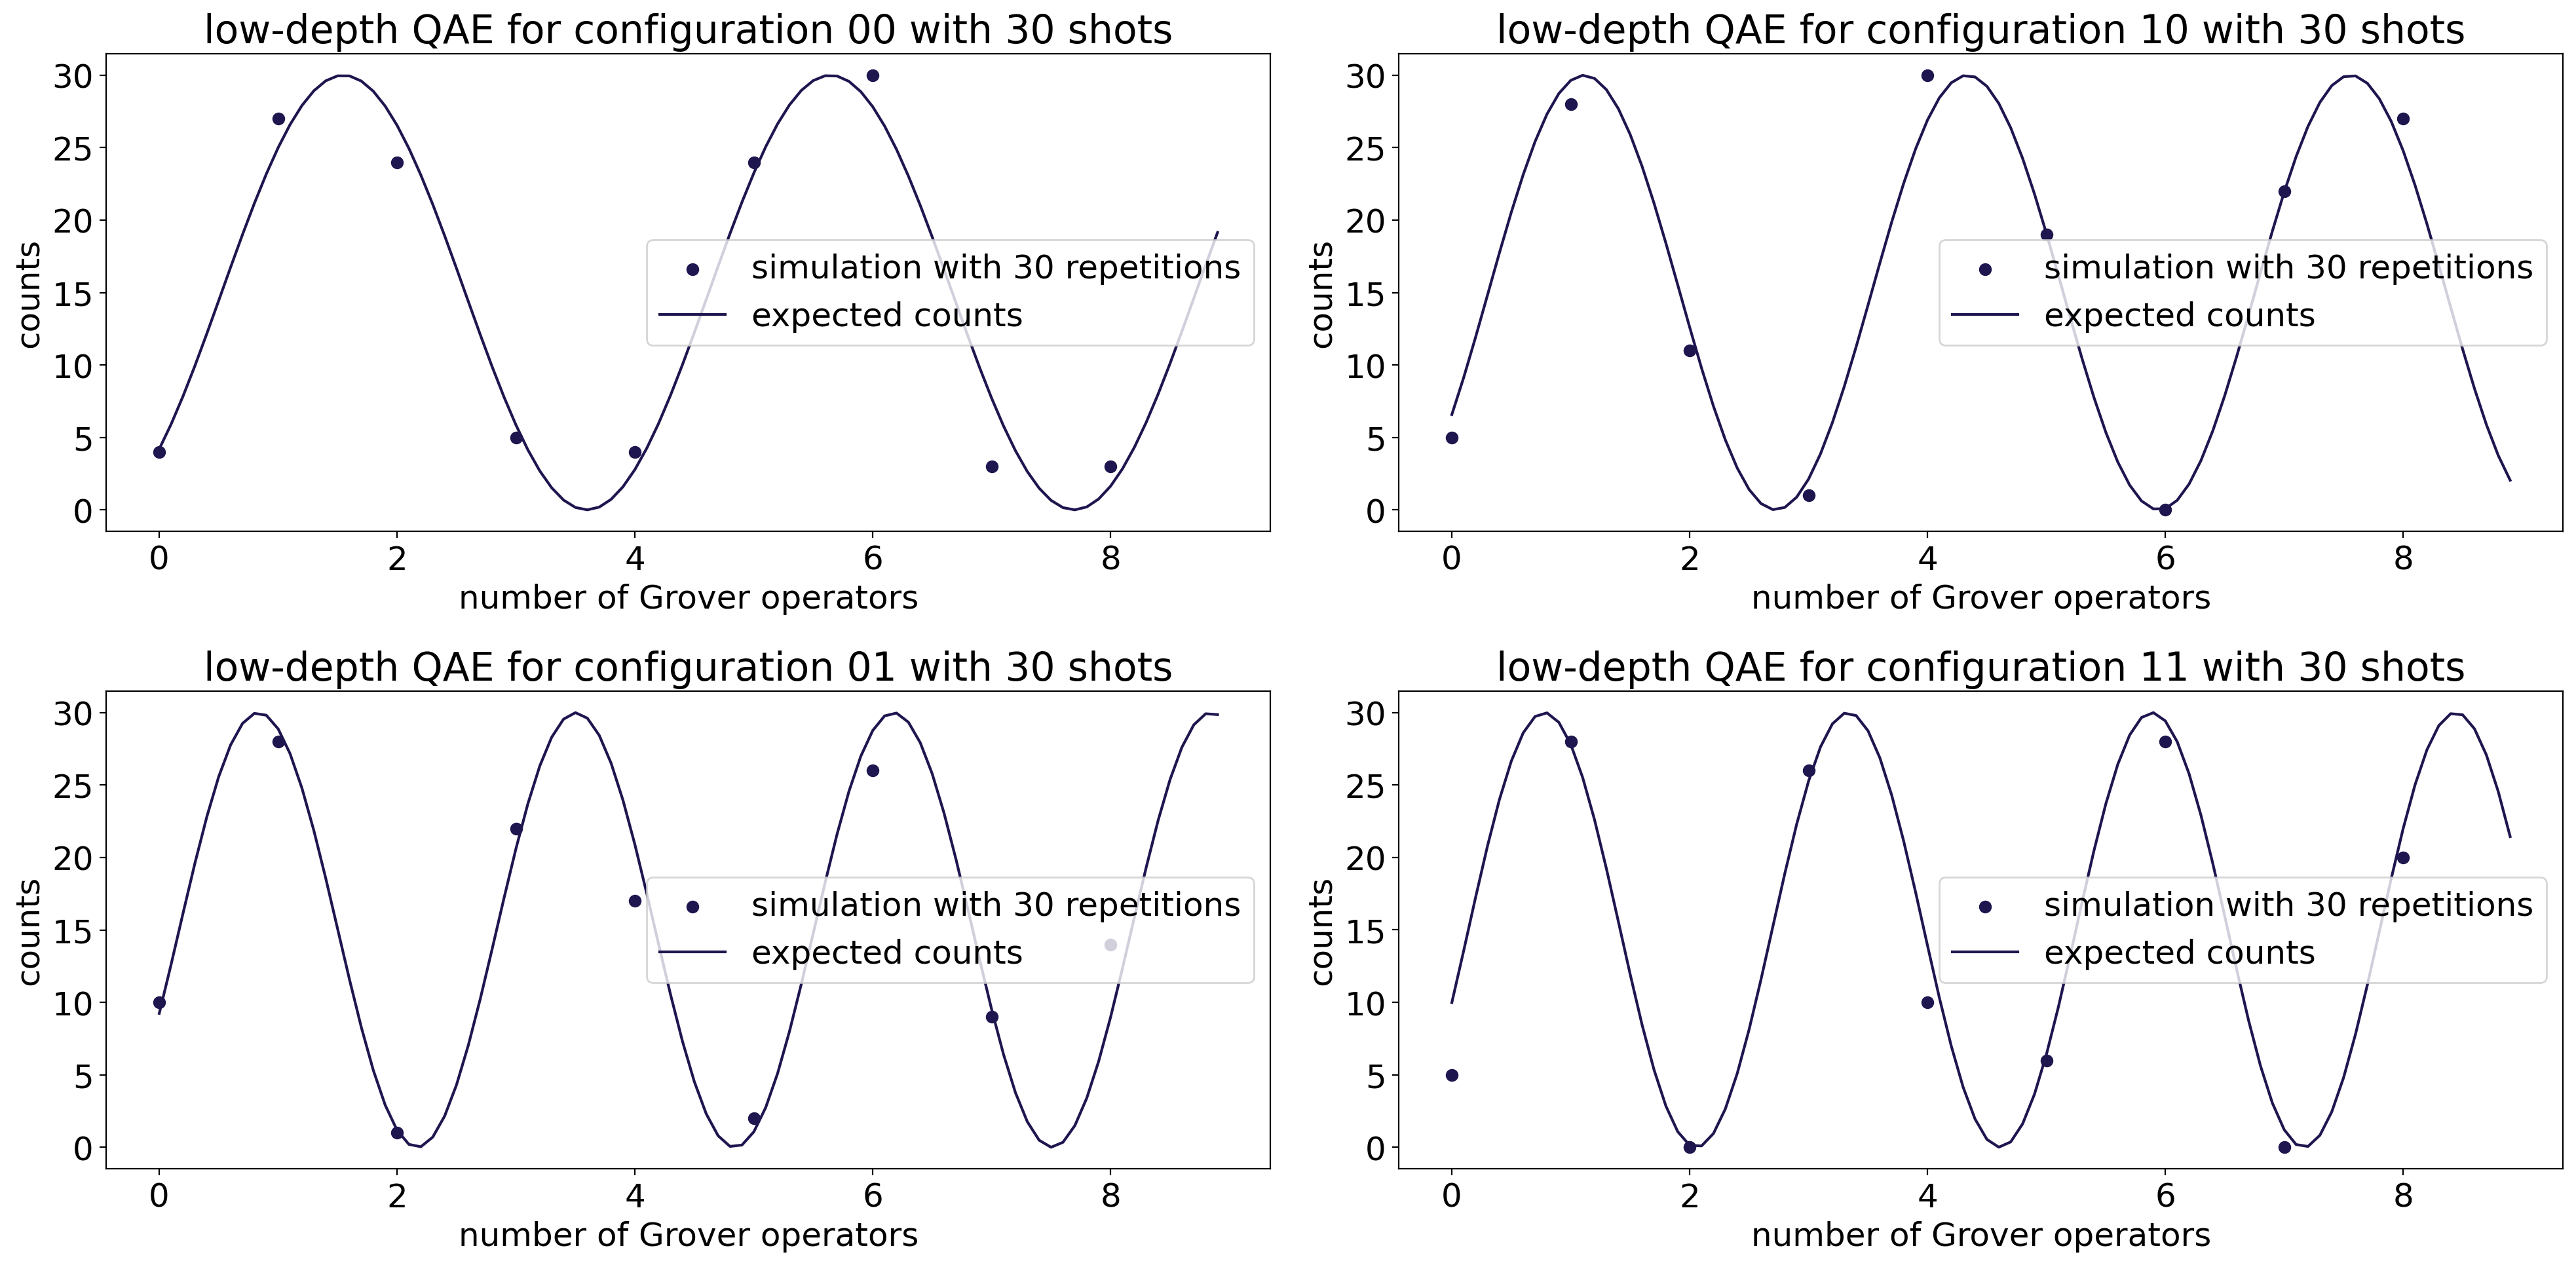

In [21]:
e00=evalues[0]
e01=evalues[2]
e10=evalues[4]
e11=evalues[6]

n=N[0]
xe3=[]
ye3_00=[]
ye3_01=[]
ye3_10=[]
ye3_11=[]
for i in range(90):
    xe3.append(i/10)
    ye3_00.append(n*math.sin((1+2*i/10)*np.angle(e00)/2)**2)
    ye3_01.append(n*math.sin((1+2*i/10)*np.angle(e01)/2)**2)
    ye3_10.append(n*math.sin((1+2*i/10)*np.angle(e10)/2)**2)
    ye3_11.append(n*math.sin((1+2*i/10)*np.angle(e11)/2)**2)
fig,axs=plt.subplots(2,2,figsize=(20,10))

axs[0,0].scatter(M_buffer[0],R_buffer[0],label='simulation with 30 repetitions',color=jos_palette[3])
axs[0,1].scatter(M_buffer[1],R_buffer[1],label='simulation with 30 repetitions',color=jos_palette[3])
axs[1,0].scatter(M_buffer[2],R_buffer[2],label='simulation with 30 repetitions',color=jos_palette[3])
axs[1,1].scatter(M_buffer[3],R_buffer[3],label='simulation with 30 repetitions',color=jos_palette[3])
axs[0,0].plot(xe3,ye3_00,label='expected counts',color=jos_palette[3])
axs[0,1].plot(xe3,ye3_01,label='expected counts',color=jos_palette[3])
axs[1,0].plot(xe3,ye3_10,label='expected counts',color=jos_palette[3])
axs[1,1].plot(xe3,ye3_11,label='expected counts',color=jos_palette[3])


for i in [0,1]:
    for j in [0,1]:
        axs[i,j].set_title('low-depth QAE for configuration '+str(j)+str(i)+' with 30 shots')
        axs[i,j].set_xlabel('number of Grover operators')
        axs[i,j].set_ylabel('counts')
        axs[i,j].legend()

fig.tight_layout()

- we use gradient descent to find an angle with corresponding probability that fits best the measurement results
- we do this optimization with the function <span style='font-family:courier'>loopGradientOptimizerVectorNoErrorModel</span> of Pygrnd module <span style='font-family:courier'>pygrnd.qc.lowDepthQAEgradientDescent</span>  
- this function performs several rounds of gradient descent with randomly chosen starting points
- we do not use an error model



In [22]:
for i in range(len(N_buffer)):
    N=N_buffer[i]
    M=M_buffer[i]
    R=R_buffer[i]
    angle, prob=loopGradientOptimizerVectorNoErrorModel(N, M, R, rounds=100, stepSize=0.0001)
    print("target=",targets[i],"correct result =",resultClassical[i],", result of low-depth QAE=",prob)

target= 00 correct result = 0.1399616 , result of low-depth QAE= 0.1441420403476047


target= 10 correct result = 0.21922239999999996 , result of low-depth QAE= 0.21882024881723583


target= 01 correct result = 0.3080864 , result of low-depth QAE= 0.3149952828509411


target= 11 correct result = 0.33272959999999996 , result of low-depth QAE= 0.3336359347956347


#### Model with one node and low-depth quantum amplitude estimation

- the complexity of the model above with 2 nodes is challenging for current hardware
- we consider a model with only one node  
- the evaluation of this model  with low\-depth QAE needs fewer higher\-controlled operations
- we are interested in the probability of the state 1 in the last time step when there is a probability for failure and for recovery
- we evaluate the results from the AQT simulator with realistic noise model \(2000 repetitions\) and from the AQT system PINE \(8000 repetitions\)



In [23]:
nodes=['n1']
probFail={'n1':0.3}
probRecovery={'n1':0.1}
edges={}

- we compare the exact probabilities with the results from Monte Carlo simulations for up to 9 time steps
- we use Monte Carlo simulations with 10000 rounds each  



In [24]:
maxTimesteps=10
xeReal=[]
yeReal=[]
xeMC=[]
yeMC=[]
for t in range(1,maxTimesteps):
    vc=classicalEvaluation(t, nodes, probFail, probRecovery, edges)
    xeReal.append(t)
    yeReal.append(vc[1]) # The second entry corresponds to the configuration 1 of the node.
    for i in range(20):
        mc=monteCarloEvaluation(t, nodes, probFail, probRecovery, edges, rounds=10000)
        xeMC.append(t)
        yeMC.append(mc[1])

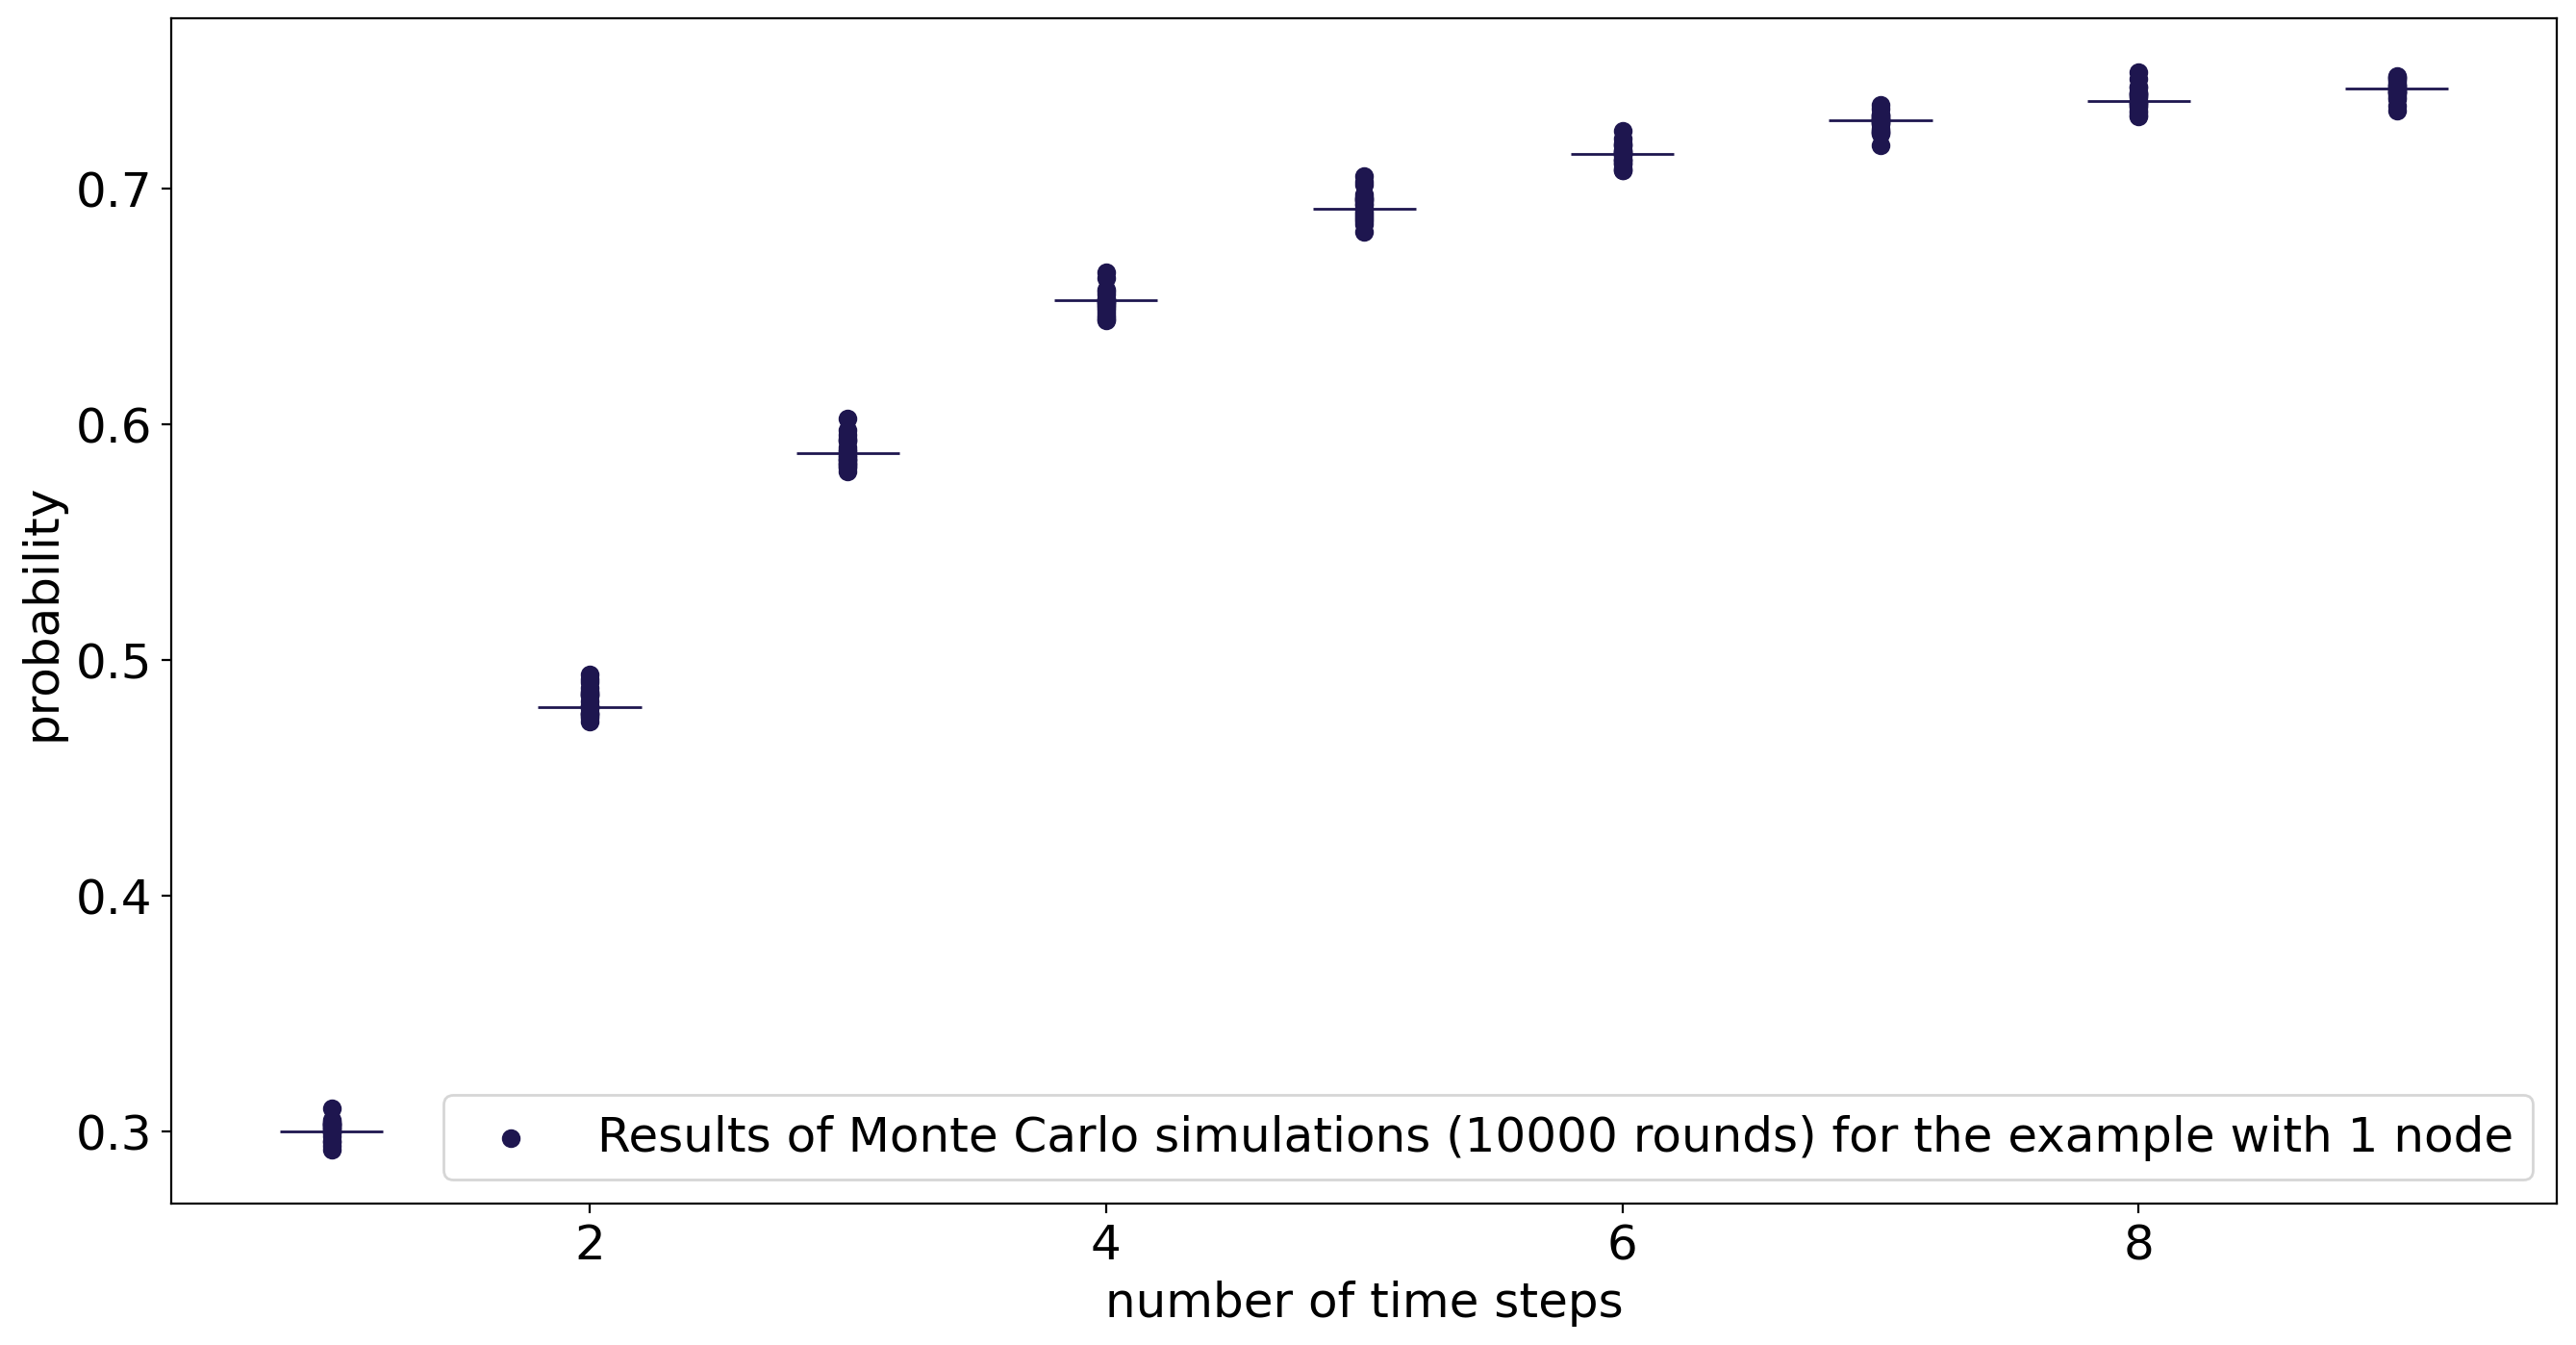

In [25]:
plt.figure(figsize=(16, 8))
for i in range(len(xeReal)):
    plt.hlines(y=yeReal[i], xmin=xeReal[i]-0.2, xmax=xeReal[i]+0.2, color=jos_palette[3],linewidth=1)
plt.scatter(xeMC,yeMC, color=jos_palette[3],label='Results of Monte Carlo simulations (10000 rounds) for the example with 1 node')
plt.xlabel('number of time steps')
plt.ylabel('probability')
plt.legend()

- we generate the Grover operators for up to 5 time steps
- we mark all states that have the configuration 1 in the last time step
- this construction uses the function <span style='font-family:courier'>constructGroverOperator</span> of module <span style='font-family:courier'>pygrnd.qc.parallelQAE</span> to construct Grover operators
- with this standard construction, we mark many states and this leads to a high complexity of the circuit  



In [26]:
maxTimesteps=5

grovers=[]
for t in range(1,maxTimesteps+1):
    model=createCircuitNoBarrierNoClassicalBits(t, nodes, probFail, probRecovery, edges).to_gate()
    target=['1'+x for x in allCombinations(t-1)]
    grovers.append(constructGroverOperator(model, target))

- we compare the non-trivial eigenvalues of the Grover operators for the different time steps with the correct probabilities

In [27]:
evalues=[]
probs=[]
for i in range(len(grovers)):
    grover=grovers[i]
    qr=QuantumRegister(i+1,'q')
    qc=QuantumCircuit(qr)
    qc.append(grover,qr)
    backend_qiskit = Aer.get_backend(name='unitary_simulator')
    job = execute(qc, backend_qiskit)
    u=job.result().get_unitary()
    from numpy.linalg import eig
    eVal,eVec=eig(u)
    for e in eVal:
        if abs(e-1)>0.001 and abs(e+1)>0.001:
            print("t=",i+1," probability for this eigenvalue=",math.sin(np.angle(e)/2)**2,"(exact value="+str(round(yeReal[i],6))+")")
            evalues.append(e)
            probs.append(math.sin(np.angle(e)/2)**2)
probs=[probs[i] for i in [0,2,4,6,8]]

t= 1  probability for this eigenvalue= 0.3000000000000001 (exact value=0.3)
t= 1  probability for this eigenvalue= 0.29999999999999993 (exact value=0.3)
t= 2  probability for this eigenvalue= 0.47999999999999987 (exact value=0.48)
t= 2  probability for this eigenvalue= 0.48 (exact value=0.48)
t= 3  probability for this eigenvalue= 0.5879999999999997 (exact value=0.588)
t= 3  probability for this eigenvalue= 0.5880000000000003 (exact value=0.588)


t= 4  probability for this eigenvalue= 0.652799999999999 (exact value=0.6528)
t= 4  probability for this eigenvalue= 0.6528000000000005 (exact value=0.6528)


t= 5  probability for this eigenvalue= 0.6916799999999864 (exact value=0.69168)
t= 5  probability for this eigenvalue= 0.6916800000000135 (exact value=0.69168)


- we generate the expected number of measurement counts for a low\-depth QAE with the exact values
- we take 30 shots for each number of time steps and for each number of Grover operators in the low\-depth QAE  



In [28]:
n= 30 # shots
xe_t=[]
ye_t1=[]
ye_t2=[]
ye_t3=[]
ye_t4=[]
ye_t5=[]
for i in range(90):
    xe_t.append(i/10)
    ye_t1.append(n*math.sin((1+2*i/10)*np.angle(evalues[0])/2)**2)
    ye_t2.append(n*math.sin((1+2*i/10)*np.angle(evalues[2])/2)**2)
    ye_t3.append(n*math.sin((1+2*i/10)*np.angle(evalues[4])/2)**2)
    ye_t4.append(n*math.sin((1+2*i/10)*np.angle(evalues[6])/2)**2)
    ye_t5.append(n*math.sin((1+2*i/10)*np.angle(evalues[8])/2)**2)

- we measure each circuit 30 times each with an error\-free simulator
- we consider up to 8 Grover operators for each number of time steps  



In [29]:
shots=30

N_buffer=[]
M_buffer=[]
R_buffer=[]

for i in range(len(grovers)):
    model=createCircuitNoBarrierNoClassicalBits(i+1, nodes, probFail, probRecovery, edges).to_gate()
    grover=grovers[i]
    N=[]
    M=[]
    R=[]
    for groverN in [0,1,2,3,4,5,6,7,8]:
        qr=QuantumRegister(i+1,'q')
        cr=ClassicalRegister(1,'c')
        qc=QuantumCircuit(qr,cr)
        qc.append(model,qr)
        for j in range(groverN):
            qc.append(grover,qr)
        qc.measure(qr[i],cr)

        backend_qiskit = Aer.get_backend(name='qasm_simulator')
        job = execute(qc, backend_qiskit,shots=shots)
        c = job.result().get_counts()
        N.append(shots)
        M.append(groverN)
        if '1' in c:
            R.append(c['1'])
        else:
            R.append(0)
    print("count vector (0 to 8 Grover after model) for",i+1,"time steps:",R)
    N_buffer.append(N)
    M_buffer.append(M)
    R_buffer.append(R)

count vector (0 to 8 Grover after model) for 1 time steps: [6, 29, 1, 23, 23, 0, 28, 12, 8]


count vector (0 to 8 Grover after model) for 2 time steps: [11, 10, 13, 17, 12, 26, 7, 26, 6]


count vector (0 to 8 Grover after model) for 3 time steps: [20, 3, 25, 0, 30, 2, 27, 7, 17]


count vector (0 to 8 Grover after model) for 4 time steps: [19, 0, 30, 1, 20, 18, 3, 30, 0]


count vector (0 to 8 Grover after model) for 5 time steps: [23, 2, 30, 10, 9, 28, 0, 21, 24]


- we draw the expected counts for the state 1 together with the results from the measurements with 30 counts each

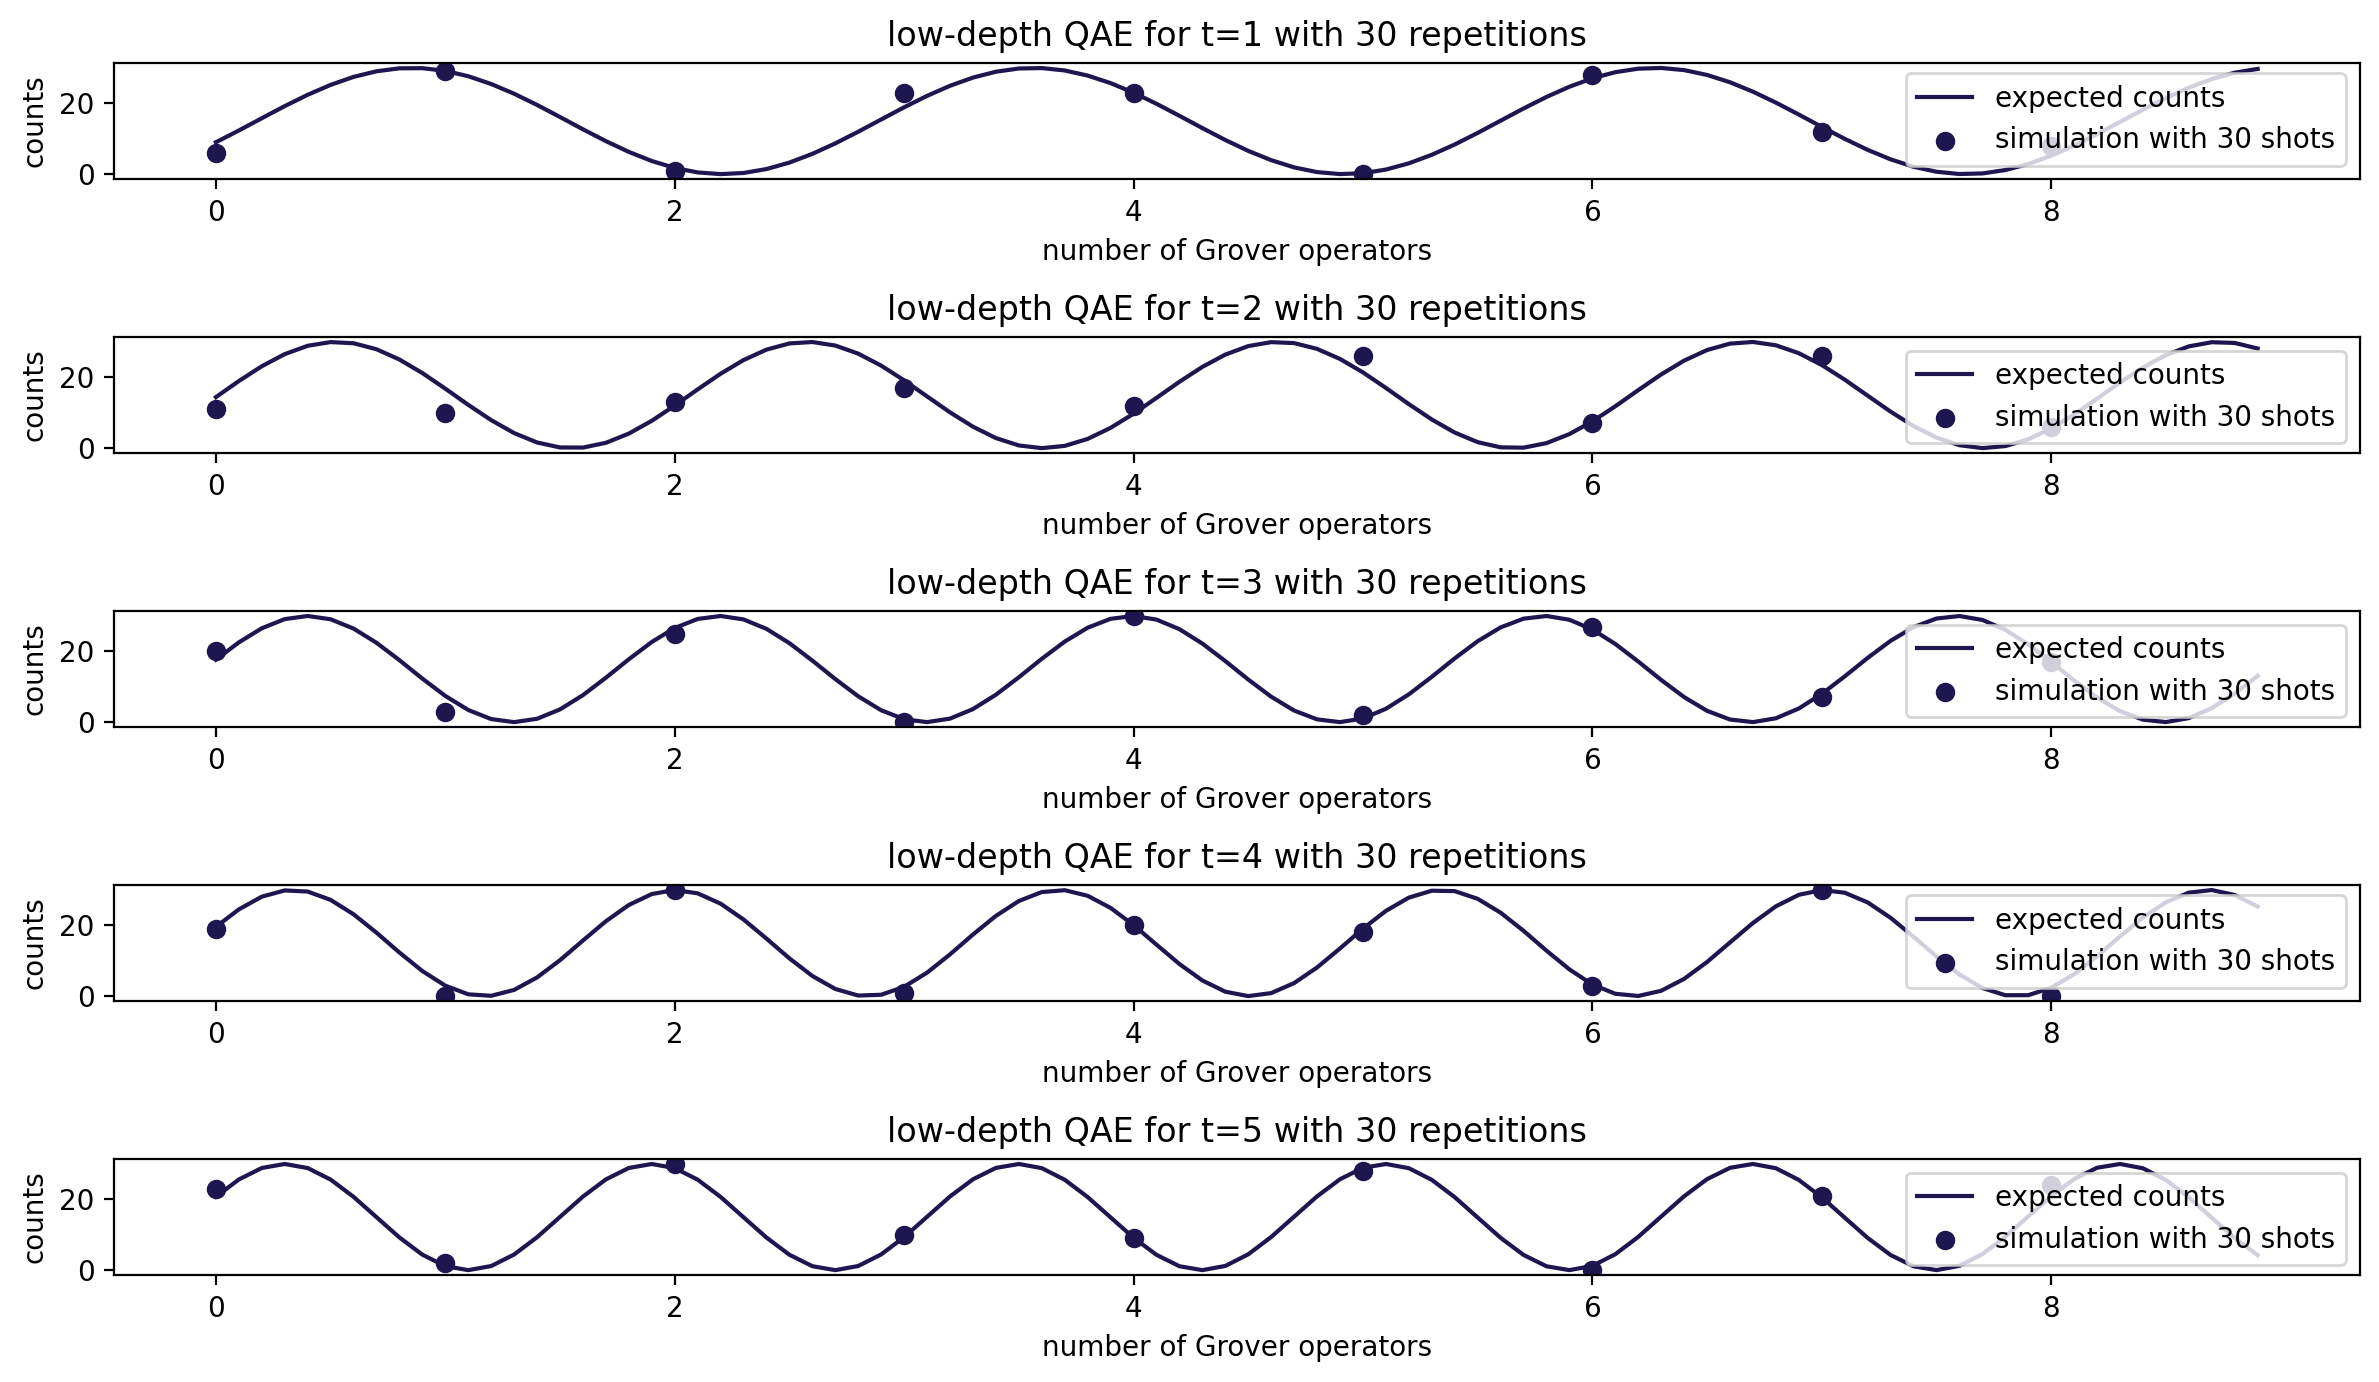

In [30]:
matplotlib.rcParams.update({'font.size': 10})
fig,axs=plt.subplots(5)

listYE=[ye_t1,ye_t2,ye_t3,ye_t4,ye_t5]

for i in range(5):
    axs[i].plot(xe_t,listYE[i],color=jos_palette[3],label='expected counts')
    axs[i].scatter(M_buffer[i],R_buffer[i],color=jos_palette[3],label='simulation with 30 shots')
    axs[i].set_title('low-depth QAE for t='+str(i+1)+' with 30 repetitions')
    axs[i].set_xlabel("number of Grover operators")
    axs[i].set_ylabel("counts")
    axs[i].legend()

fig.tight_layout()

- we use gradient descent function <span style='font-family:courier'>loopGradientOptimizerVector</span> of Pygrnd to fit the angle to the results from the measurements  
- we do not use an error model



In [31]:
from pygrnd.qc.MaximumLikelihoodForQAEwoPE import *
for i in range(len(N_buffer)):
    N=N_buffer[i]
    M=M_buffer[i]
    R=R_buffer[i]
    angle,prob=loopGradientOptimizerVector(N, M, R, rounds=100, stepSize=0.0001)
    print("time steps:",i+1,"correct probability=",probs[i],", result low-depth QAE=",prob)

time steps: 1 correct probability= 0.3000000000000001 , result low-depth QAE= 0.30414013025738323
time steps: 2 correct probability= 0.47999999999999987 , result low-depth QAE= 0.47855295746562015


time steps: 3 correct probability= 0.5879999999999997 , result low-depth QAE= 0.5886089621669186
time steps: 4 correct probability= 0.652799999999999 , result low-depth QAE= 0.6491045088637739


time steps: 5 correct probability= 0.6916799999999864 , result low-depth QAE= 0.6907057305885542


#### Evaluation of results from simulator with noise model

- we use the results from the AQT simulator with a realistic noise model
- we run 2000 shots for up to 4 time steps and for up to 8 Grover operators in low\-depth QAE circuits
- for the simulation, we used a modified construction of the Grover operator  
- this modified construction of the Grover operator marks the qubit corresponding to the last time step with a $Z$ gate
- the Qiskit transpiler was used with <span style='font-family:courier'>optimization\_level=3</span>



In [32]:
#
# Generate reference data.
#
n=2000

exactProbs=[0.3, 0.48, 0.588, 0.6528]
angles=[]
for p in exactProbs:
    angles.append(2*math.asin(math.sqrt(p)))

xe_t=[]
ye_t1=[]
ye_t2=[]
ye_t3=[]
ye_t4=[]
for i in range(90):
    xe_t.append(i/10)
    ye_t1.append(n*math.sin((1+2*i/10)*angles[0]/2)**2)
    ye_t2.append(n*math.sin((1+2*i/10)*angles[1]/2)**2)
    ye_t3.append(n*math.sin((1+2*i/10)*angles[2]/2)**2)
    ye_t4.append(n*math.sin((1+2*i/10)*angles[3]/2)**2)

- we read in the data from the AQT simulator with a realistic noise model  



In [33]:
N_buffer=[]
M_buffer=[]
R_buffer=[]

N=[2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000]
M=[0, 1, 2, 3, 4, 5, 6, 7, 8]
R=[617, 1958,  121, 1265, 1516,   12, 1817,  928, 344]
N_buffer.append(N)
M_buffer.append(M)
R_buffer.append(R)

N=[2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000]
M=[0, 1, 2, 3, 4, 5, 6, 7, 8]
R=[981, 1181,  760, 1365,  595, 1384,  717, 1283, 807]
N_buffer.append(N)
M_buffer.append(M)
R_buffer.append(R)

N=[2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000]
M=[0, 1, 2, 3, 4, 5, 6, 7, 8]
R=[1236,  841, 1153,  931, 1033,  988,  983, 1018, 979]
N_buffer.append(N)
M_buffer.append(M)
R_buffer.append(R)

N=[2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000]
M=[0, 1, 2, 3, 4, 5, 6, 7, 8]
R=[1423,  969,  991, 1026,  979, 1002,  983, 1012, 986]
N_buffer.append(N)
M_buffer.append(M)
R_buffer.append(R)

- we use the gradient descent function <span style='font-family:courier'>loopGradientOptimizerVectorErrorModel</span> of Pygrnd to fit the error model with the exponential factor to the results of the simulation  



In [34]:
resThetas=[]
resAs=[]
resFs=[]
resProbs=[]
for i in range(len(N_buffer)):
    resTheta,resA,resF,resProb=loopGradientOptimizerVectorErrorModel(N_buffer[i], M_buffer[i], R_buffer[i], rounds=200, stepSize=0.0001, learningRate=0.0001)
    resThetas.append(getSmallerAngle(resTheta))
    resAs.append(resA)
    resFs.append(resF)
    resProbs.append(resProb)
    print("fitted values: theta=",resTheta,"a=",resA,"f=",resF,"estimated probability=",resProb,"correct value=",exactProbs[i])

fitted values: theta= 1.1584807045937309 a= -0.0016123010749134296 f= 0.1931636809556455 estimated probability= 0.29963401863366296 correct value= 0.3


fitted values: theta= 1.4883363901062037 a= 0.1644733472589574 f= 0.5076258356412723 estimated probability= 0.4588167406042417 correct value= 0.48


fitted values: theta= 1.7632763023860656 a= 0.9788034865023355 f= 0.5042413190339706 estimated probability= 0.5956468291232648 correct value= 0.588


fitted values: theta= 1.989592535406382 a= 1.8126927513704003 f= 0.5056668445806816 estimated probability= 0.7033304946380746 correct value= 0.6528


- for comparing the results without error model and with error model, we use the gradient descent function <span style='font-family:courier'>loopGradientOptimizerVector</span> of Pygrnd 
- this functions fits the angle to the results of the simulation without using the error model  
- the results for t=3 and t=4 are close to 0.5, which corresponds to random output as expected in the noise model



In [35]:
resThetasNoEM=[]
resProbsNoEM=[]
for i in range(len(N_buffer)):
    resTheta,resProb=loopGradientOptimizerVectorNoErrorModel(N_buffer[i], M_buffer[i], R_buffer[i], rounds=200, stepSize=0.0001, learningRate=0.0001)
    resThetasNoEM.append(getSmallerAngle(resTheta))
    resProbsNoEM.append(resProb)
    print("fitted values: theta=",resTheta,"estimated probability=",resProb,"correct value=",exactProbs[i])

fitted values: theta= 1.1584992885904775 estimated probability= 0.29964253195383567 correct value= 0.3


fitted values: theta= 1.540130513389541 estimated probability= 0.4846694963417483 correct value= 0.48


fitted values: theta= 1.5735925913697322 estimated probability= 0.5013981304653968 correct value= 0.588


fitted values: theta= 1.5703216040393657 estimated probability= 0.4997626386311499 correct value= 0.6528


- we generate the expected counts for the error models that were found by gradient descent
- for comparison, we also create the expected counts for the case without error model  
- we generate counts for non\-integer values to make the curve more visible



In [36]:
xe2_t=[]
ye2_t1=[]
ye2_t2=[]
ye2_t3=[]
ye2_t4=[]
for i in range(90):
    xe2_t.append(i/10)
    ye2_t1.append(n*expectedProbabilityErrorModel(resThetas[0], i/10, resAs[0], resFs[0]))
    ye2_t2.append(n*expectedProbabilityErrorModel(resThetas[1], i/10, resAs[1], resFs[1]))
    ye2_t3.append(n*expectedProbabilityErrorModel(resThetas[2], i/10, resAs[2], resFs[2]))
    ye2_t4.append(n*expectedProbabilityErrorModel(resThetas[3], i/10, resAs[3], resFs[3]))

In [37]:
xe3_t=[]
ye3_t1=[]
ye3_t2=[]
ye3_t3=[]
ye3_t4=[]
for i in range(90):
    xe3_t.append(i/10)
    ye3_t1.append(n*expectedProbabilityNoErrorModel(resThetasNoEM[0], i/10))
    ye3_t2.append(n*expectedProbabilityNoErrorModel(resThetasNoEM[1], i/10))
    ye3_t3.append(n*expectedProbabilityNoErrorModel(resThetasNoEM[2], i/10))
    ye3_t4.append(n*expectedProbabilityNoErrorModel(resThetasNoEM[3], i/10))

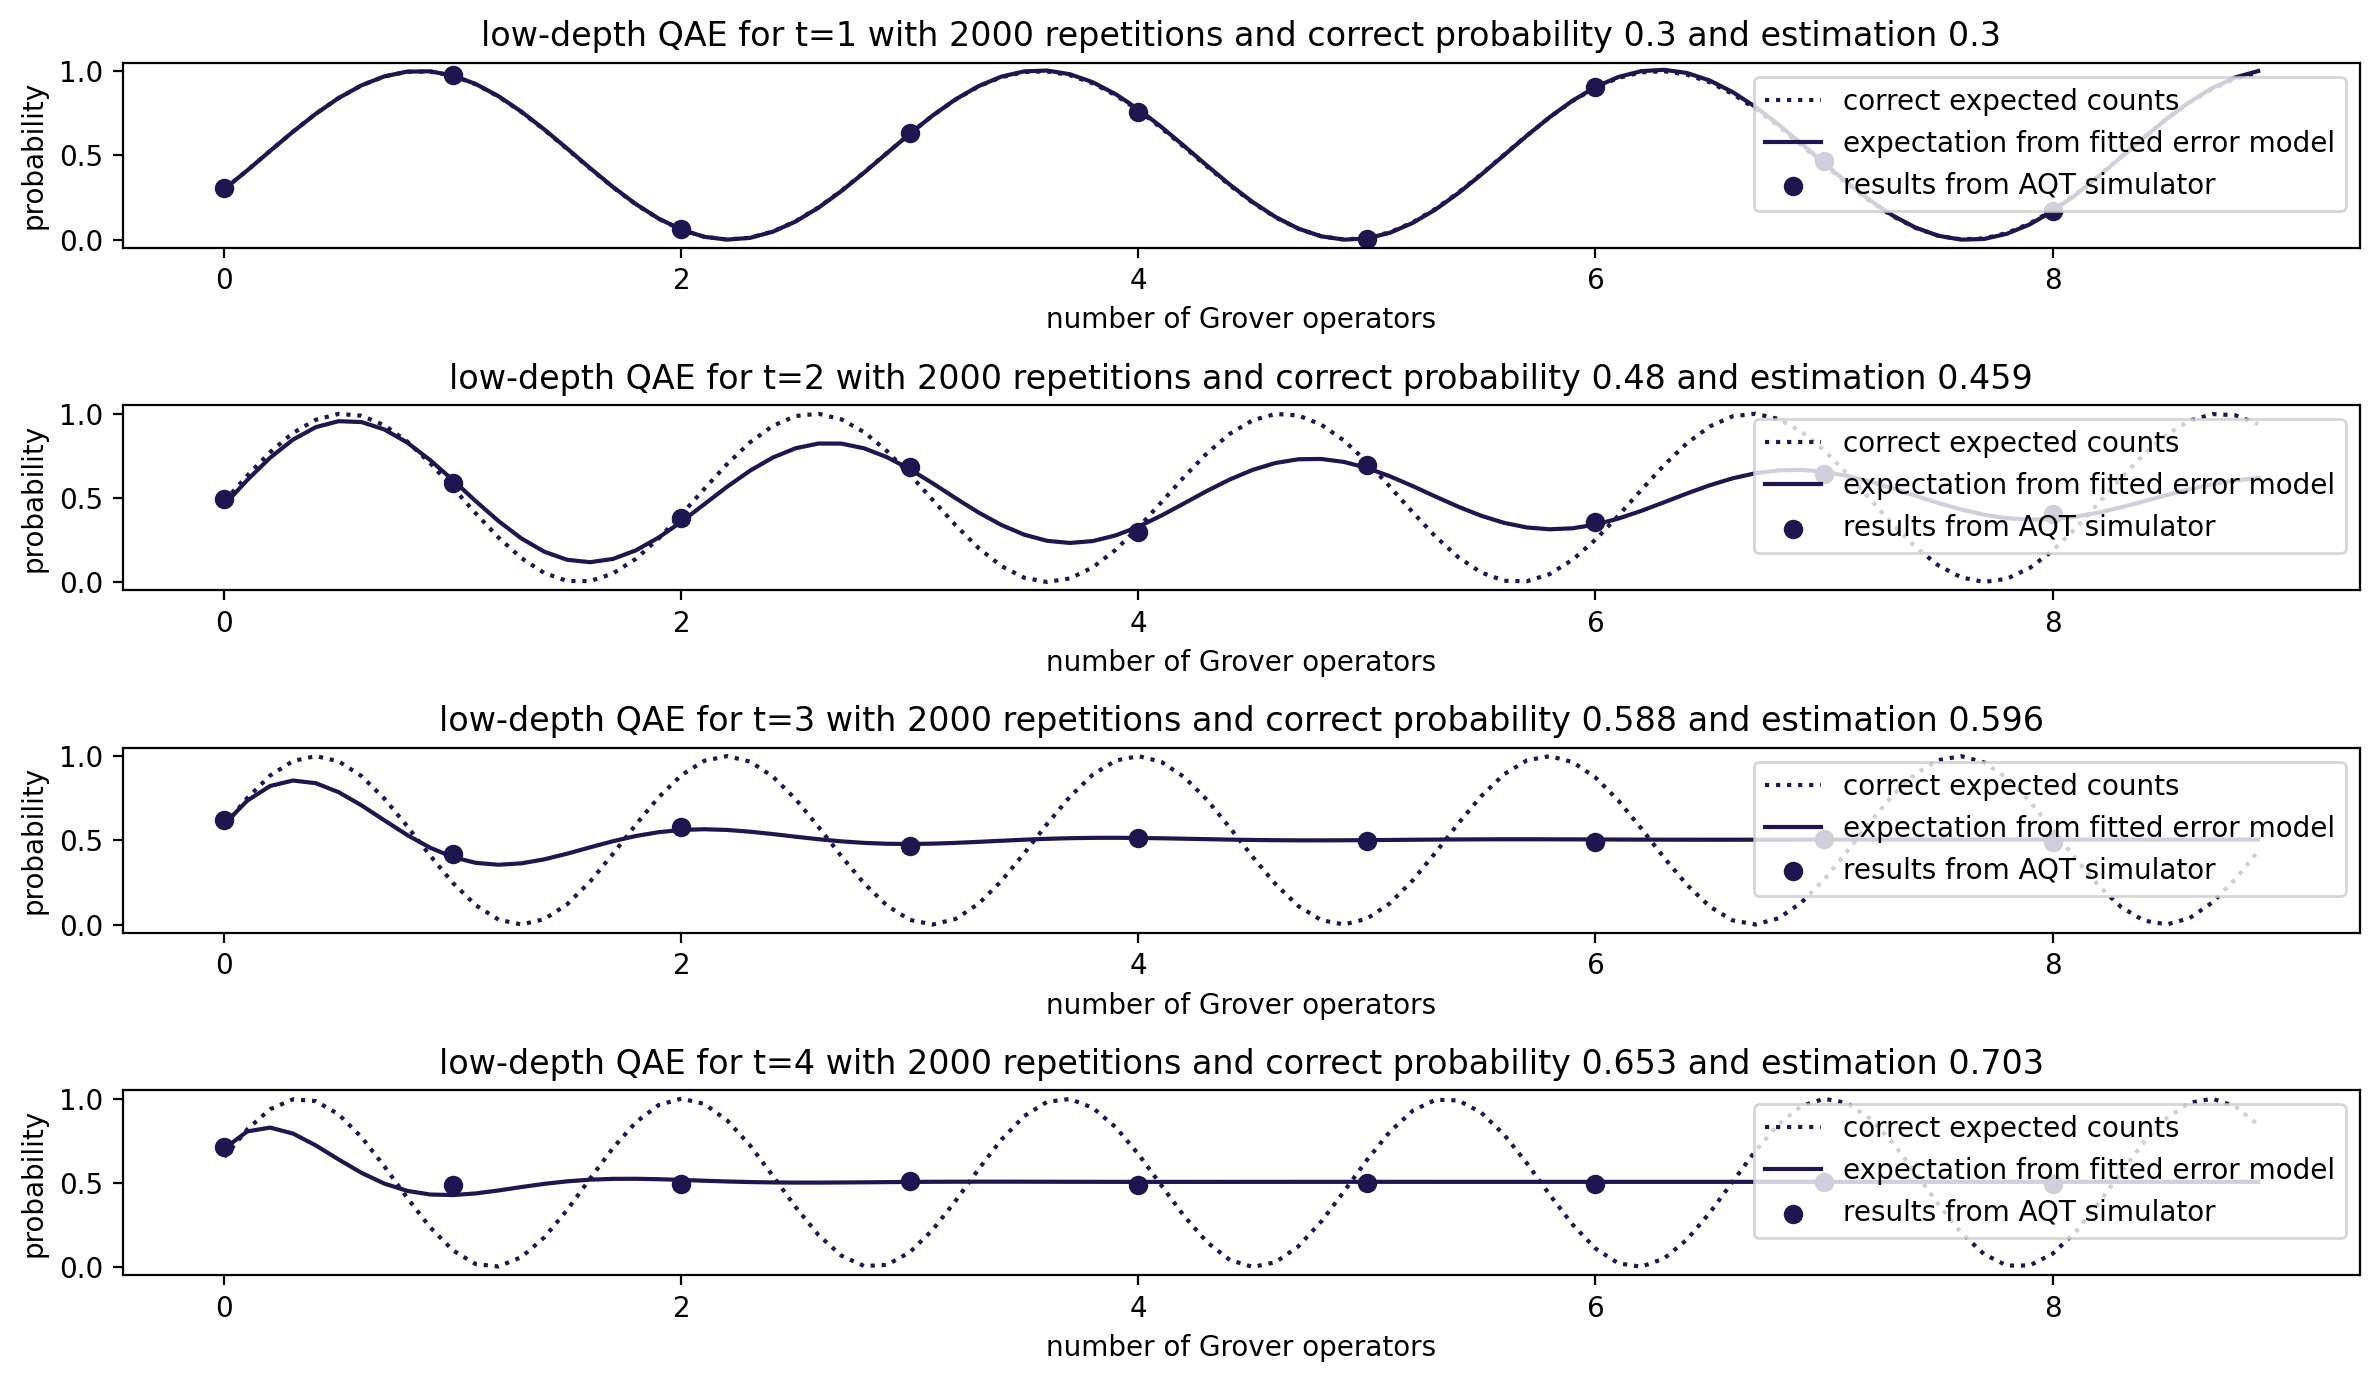

In [38]:
matplotlib.rcParams.update({'font.size': 10})
fig,axs=plt.subplots(4)

listYE=[ye_t1,ye_t2,ye_t3,ye_t4]
listYE2=[ye2_t1,ye2_t2,ye2_t3,ye2_t4]
listYE3=[ye3_t1,ye3_t2,ye3_t3,ye3_t4]

for i in range(4):
    # The curves for the probabilities without error for the correct probabilities.
    axs[i].plot(xe_t,[y/n for y in listYE[i]],linestyle='dotted',color=jos_palette[3],label='correct expected counts')
    # The curves for the probabilities for the error model, which were found by gradient descent.
    axs[i].plot(xe2_t,[y/n for y in listYE2[i]],linestyle='solid',color=jos_palette[3],label='expectation from fitted error model')
    # The curves for the probabilities for the fits without error model, which were found by gradient descent.
    # axs[i].plot(xe3_t,[y/n for y in listYE3[i]],linestyle='dotted',color=jos_palette[1],label='expectation without model')
    # The results from the simulation with noise model.
    axs[i].scatter(M_buffer[i],[y/n for y in R_buffer[i]],color=jos_palette[3],label='results from AQT simulator')
    axs[i].set_title('low-depth QAE for t='+str(i+1)+' with 2000 repetitions and correct probability '+str(round(exactProbs[i],3))+' and estimation '+str(round(resProbs[i],3)))
    axs[i].set_xlabel('number of Grover operators')
    axs[i].set_ylabel('probability')
    axs[i].set_ylim([-0.05, 1.05])
    axs[i].legend(loc='upper right')

fig.tight_layout()

#### Evaluation of results from AQT system PINE

- for 1 and 2 time steps we apply up to 8 Grover operators in circuits for low\-depth QAE
- for 3 and 4 time steps we apply up to 4 Grover operators
- for the experiments we used a modified construction of the Grover operator
- the construction of the Grover operator marks the qubit corresponding to the last time step with a $Z$ gate
- the Qiskit transpiler was used with <span style='font-family:courier'>optimization\_level=3</span>  



In [39]:
#
# Generate reference data.
#
n=8000

exactProbs=[0.3, 0.48, 0.588, 0.6528]
angles=[]
for p in exactProbs:
    angles.append(2*math.asin(math.sqrt(p)))

xe_t=[]
ye_t1=[]
ye_t2=[]
ye_t3=[]
ye_t4=[]
for i in range(90):
    xe_t.append(i/10)
    ye_t1.append(n*math.sin((1+2*i/10)*angles[0]/2)**2)
    ye_t2.append(n*math.sin((1+2*i/10)*angles[1]/2)**2)
    ye_t3.append(n*math.sin((1+2*i/10)*angles[2]/2)**2)
    ye_t4.append(n*math.sin((1+2*i/10)*angles[3]/2)**2)

- we read in the data from the AQT system PINE  



In [40]:
N_buffer=[]
M_buffer=[]
R_buffer=[]

N=[8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000]
M=[0, 1, 2, 3, 4, 5, 6, 7]
R=[2386, 7867, 494, 5107, 6283, 84, 7450, 3689]
N_buffer.append(N)
M_buffer.append(M)
R_buffer.append(R)

N=[8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000]
M=[0, 1, 2, 3, 4, 5, 6, 7]
R=[4545, 4275, 3133, 5118, 3110, 5316, 1639, 6446]
N_buffer.append(N)
M_buffer.append(M)
R_buffer.append(R)

N=[8000, 8000, 8000, 8000, 8000]
M=[0, 1, 2, 3, 4]
R=[5211, 2505, 5171, 2336, 5353]
N_buffer.append(N)
M_buffer.append(M)
R_buffer.append(R)

N=[8000, 8000, 8000, 8000, 8000]
M=[0, 1, 2, 3, 4]
R=[5609, 2695, 4678, 3510, 4171]
N_buffer.append(N)
M_buffer.append(M)
R_buffer.append(R)

- we use the gradient descent function <span style='font-family:courier'>loopGradientOptimizerVectorErrorModel</span> of Pygrnd to fit the error model with the exponential factor to the results of the simulation  



In [41]:
resThetas=[]
resAs=[]
resFs=[]
resProbs=[]
for i in range(len(N_buffer)):
    resTheta,resA,resF,resProb=loopGradientOptimizerVectorErrorModel(N_buffer[i], M_buffer[i], R_buffer[i], rounds=200, stepSize=0.0001, learningRate=0.0001)
    resThetas.append(getSmallerAngle(resTheta))
    resAs.append(resA)
    resFs.append(resF)
    resProbs.append(resProb)
    print("fitted values: theta=",resTheta,"a=",resA,"f=",resF,"estimated probability=",resProb,"correct value=",exactProbs[i])

fitted values: theta= 5.124066645525544 a= -0.005974132830117988 f= 0.0755050658289392 estimated probability= 0.2999263060289057 correct value= 0.3


fitted values: theta= 4.737554090315383 a= -0.07746203946682359 f= 0.5224051106610854 estimated probability= 0.4874187730451206 correct value= 0.48


fitted values: theta= 1.7299927963476986 a= 0.27983878969686715 f= 0.4646629925991486 estimated probability= 0.5792624440431625 correct value= 0.588


fitted values: theta= 4.360056137857254 a= 0.9001621590542915 f= 0.49657705718874445 estimated probability= 0.6725441405152366 correct value= 0.6528


- for comparing the results without error model and with error model, we use the gradient descent function <span style='font-family:courier'>loopGradientOptimizerVector</span> of Pygrnd  
- the results for t=3 and t=4 are close to 0.5, which corresponds to random output as expected in the noise model



In [42]:
resThetasNoEM=[]
resProbsNoEM=[]
for i in range(len(N_buffer)):
    resTheta,resProb=loopGradientOptimizerVectorNoErrorModel(N_buffer[i], M_buffer[i], R_buffer[i], rounds=200, stepSize=0.0001, learningRate=0.0001)
    resThetasNoEM.append(getSmallerAngle(resTheta))
    resProbsNoEM.append(resProb)
    print("fitted values: theta=",resTheta,"estimated probability=",resProb,"correct value=",exactProbs[i])

fitted values: theta= 5.124463482221328 estimated probability= 0.299744481133854 correct value= 0.3


fitted values: theta= 4.751200824724477 estimated probability= 0.4805989495115969 correct value= 0.48


fitted values: theta= 4.656168320775037 estimated probability= 0.5280955237985685 correct value= 0.588


fitted values: theta= 1.5919804068425945 estimated probability= 0.510591247818381 correct value= 0.6528


- we generate the expected counts for the error models that were found by gradient descent
- for comparison, we also create the expected counts for the case without error model
- we generate counts for non\-integer values to make the curve more visible



In [43]:
xe2_t=[]
ye2_t1=[]
ye2_t2=[]
ye2_t3=[]
ye2_t4=[]
for i in range(90):
    xe2_t.append(i/10)
    ye2_t1.append(n*expectedProbabilityErrorModel(resThetas[0], i/10, resAs[0], resFs[0]))
    ye2_t2.append(n*expectedProbabilityErrorModel(resThetas[1], i/10, resAs[1], resFs[1]))
    ye2_t3.append(n*expectedProbabilityErrorModel(resThetas[2], i/10, resAs[2], resFs[2]))
    ye2_t4.append(n*expectedProbabilityErrorModel(resThetas[3], i/10, resAs[3], resFs[3]))

In [44]:
xe3_t=[]
ye3_t1=[]
ye3_t2=[]
ye3_t3=[]
ye3_t4=[]
for i in range(90):
    xe3_t.append(i/10)
    ye3_t1.append(n*expectedProbabilityNoErrorModel(resThetasNoEM[0], i/10))
    ye3_t2.append(n*expectedProbabilityNoErrorModel(resThetasNoEM[1], i/10))
    ye3_t3.append(n*expectedProbabilityNoErrorModel(resThetasNoEM[2], i/10))
    ye3_t4.append(n*expectedProbabilityNoErrorModel(resThetasNoEM[3], i/10))

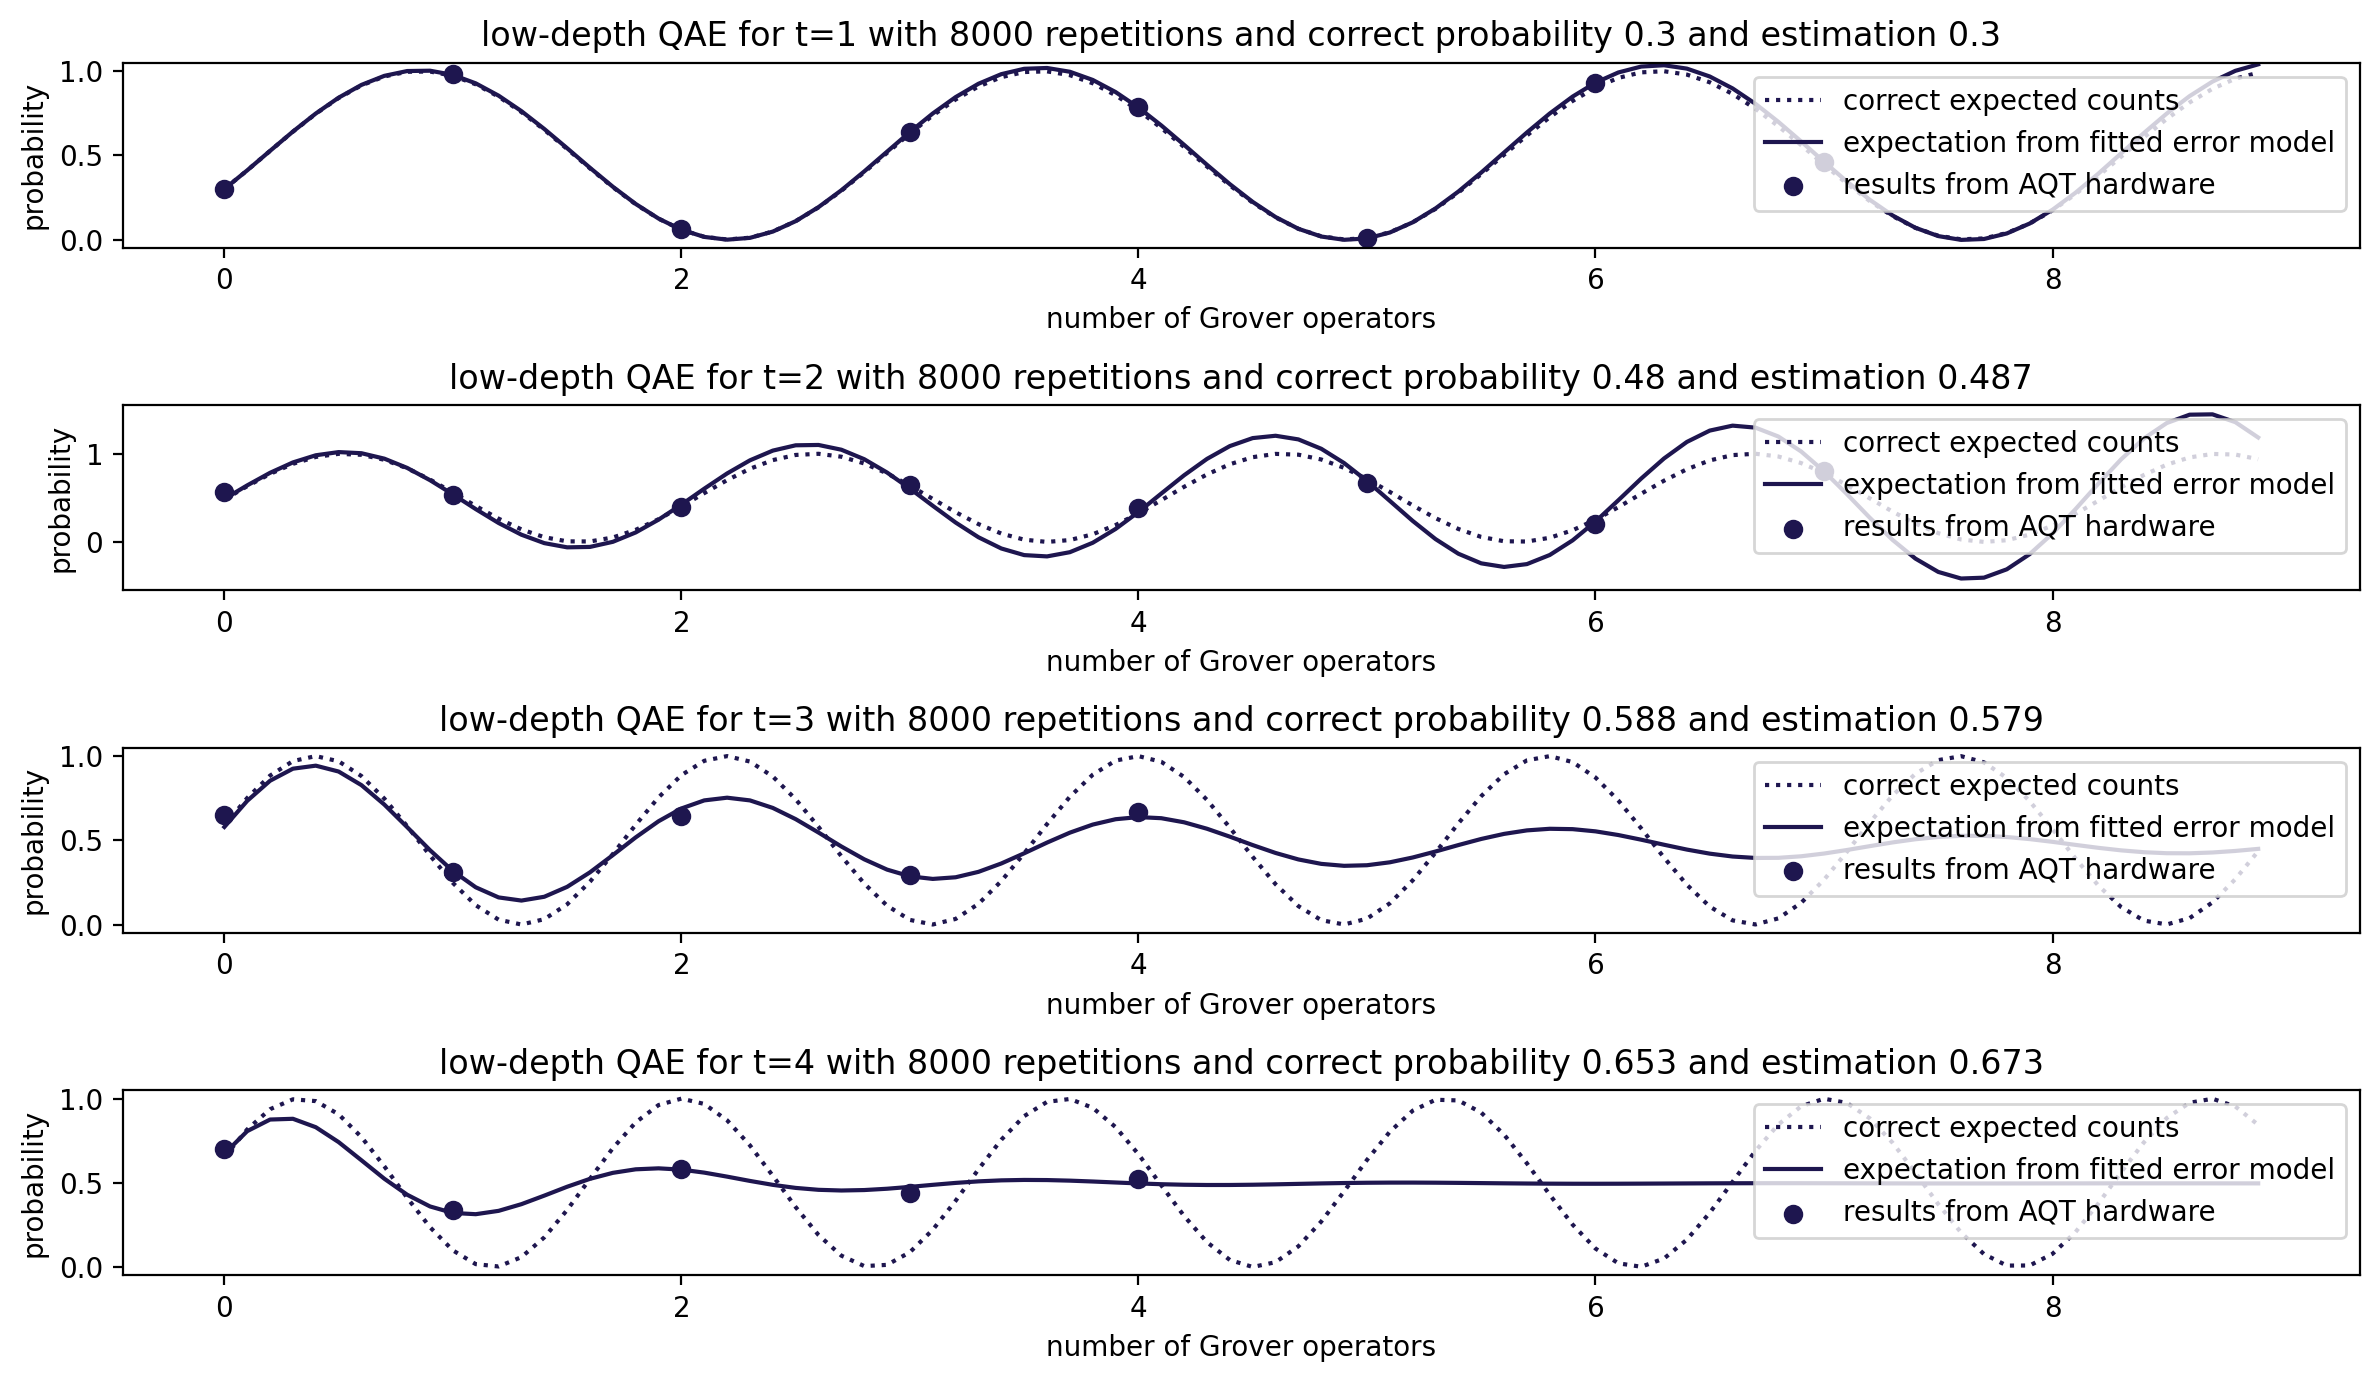

In [45]:
fig,axs=plt.subplots(4)

listYE=[ye_t1,ye_t2,ye_t3,ye_t4]
listYE2=[ye2_t1,ye2_t2,ye2_t3,ye2_t4]
listYE3=[ye3_t1,ye3_t2,ye3_t3,ye3_t4]

# The limits are different because for t=2 the model does not fit well.
for i in [0,2,3]:
    axs[i].set_ylim([-0.05, 1.05])
axs[1].set_ylim([-0.55, 1.55])

for i in range(4):
    # The curves for the probabilities without error for the correct probabilities.
    axs[i].plot(xe_t,[y/n for y in listYE[i]],linestyle='dotted',color=jos_palette[3],label='correct expected counts')
    # The curves for the probabilities for the error model, which were found by gradient descent.
    axs[i].plot(xe2_t,[y/n for y in listYE2[i]],linestyle='solid',color=jos_palette[3],label='expectation from fitted error model')
    # The curves for the probabilities for the fits without error model, which were found by gradient descent.
    # axs[i].plot(xe3_t,[y/n for y in listYE3[i]],color=jos_palette[1],label='expectation without model')
    # The results from AQT hardware.
    axs[i].scatter(M_buffer[i],[y/n for y in R_buffer[i]],color=jos_palette[3],label='results from AQT hardware')
    axs[i].set_title('low-depth QAE for t='+str(i+1)+' with 8000 repetitions and correct probability '+str(round(exactProbs[i],3))+' and estimation '+str(round(resProbs[i],3)))
    axs[i].set_xlabel('number of Grover operators')
    axs[i].set_ylabel('probability')
    axs[i].legend(loc='upper right')

fig.tight_layout()

#### Evaluation of results from different noise models

- we use a Qiskit noise model to simulate depolarizing errors on CX gates  



In [46]:
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (NoiseModel, depolarizing_error)

noise_model = NoiseModel()
error = depolarizing_error(0.02, 2)
noise_model.add_all_qubit_quantum_error(error, ['cx'])
backend_noise = AerSimulator(noise_model=noise_model)
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['cx']
  All-qubits errors: ['cx']


- we use 100 repetitions for each data point
- we modify the probabilities of the probabilistic network to smaller values  



In [47]:
shotNumber=100

nodes=['n1']
probFail={'n1':0.03}
probRecovery={'n1':0.1}
edges={}

In [48]:
maxTimesteps=4
xeReal=[]
yeReal=[]
for t in range(1,maxTimesteps+1):
    vc=classicalEvaluation(t, nodes, probFail, probRecovery, edges)
    xeReal.append(t)
    yeReal.append(vc[1]) # The second entry corresponds to the configuration 1 of the node.

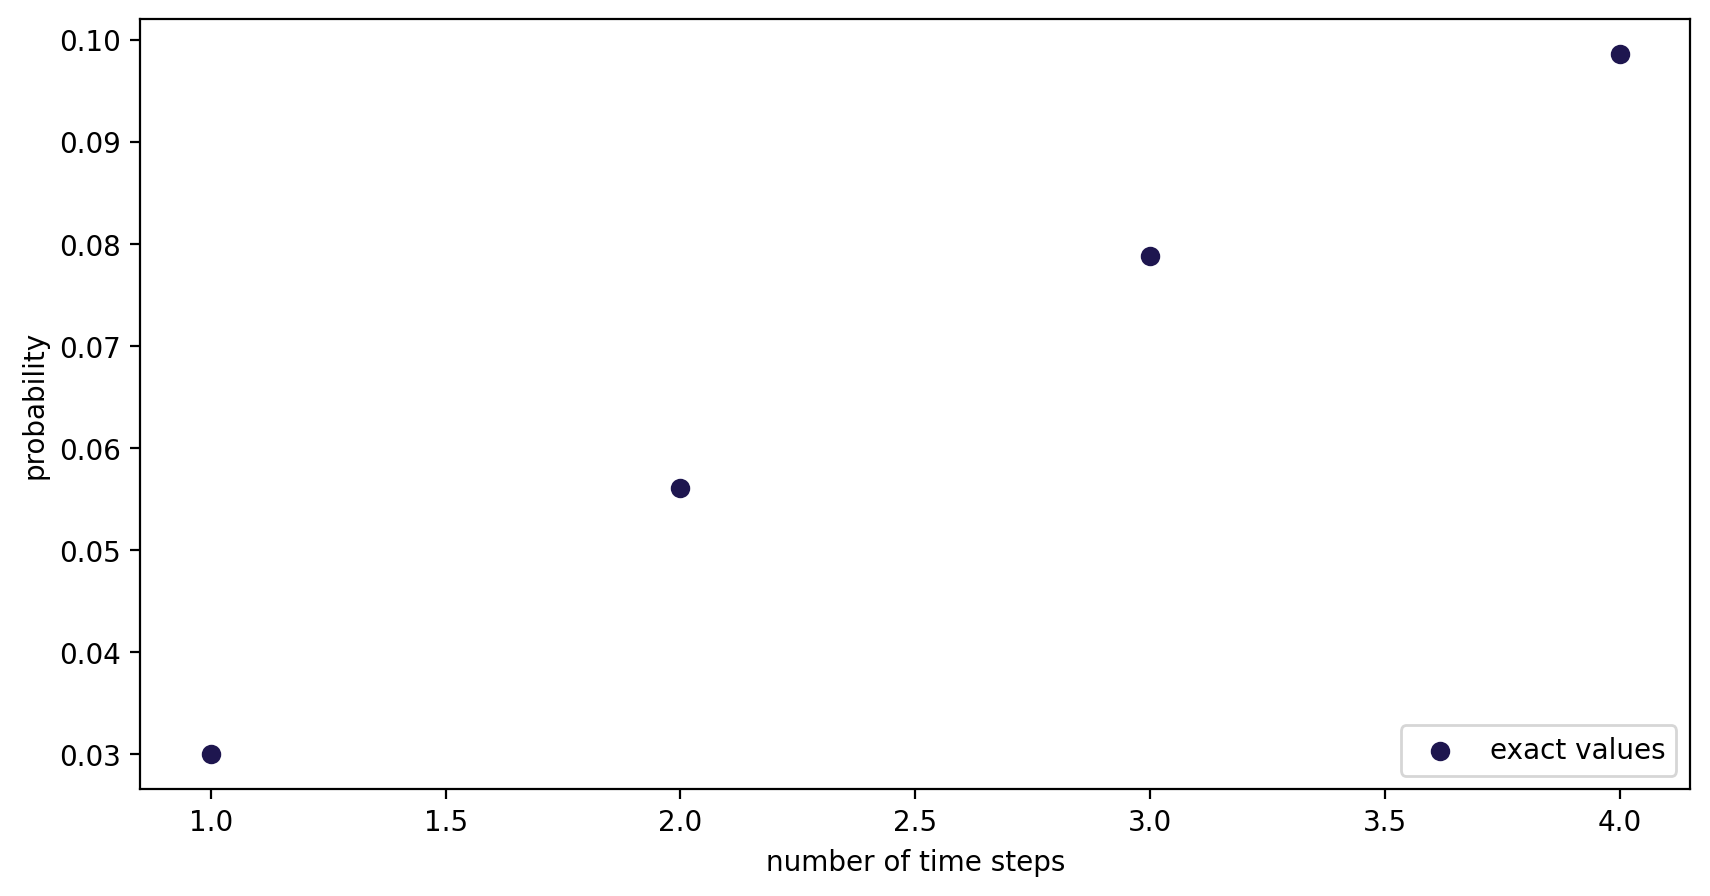

In [49]:
plt.figure(figsize=(10, 5))
plt.scatter(xeReal,yeReal,color=jos_palette[3],label='exact values')
plt.xlabel('number of time steps')
plt.ylabel('probability')
plt.legend(loc=4)

- we generate the Grover operators with the modified function <span style='font-family:courier'>constructGroverOperatorWithPhaseGateOnLastTimeStep</span> of Pygrnd
- this functions uses the provided $Z$ operation on the qubit corresponding to the last time step to mark the good states  



In [50]:
grovers=[]
for t in range(1,maxTimesteps+1):
    model=createCircuitNoBarrierNoClassicalBits(t, nodes, probFail, probRecovery, edges).to_gate()
    target=['1'+x for x in allCombinations(t-1)]
    grovers.append(constructGroverOperatorWithPhaseGateOnLastTimeStep(model,ZGate(),len(nodes)))

- we calculate the non\-trivial eigenvalues of the Grover operators and the corresponding probabilities of the good states  



In [51]:
evalues=[]
probs=[]
for i in range(len(grovers)):
    grover=grovers[i]
    qr=QuantumRegister(i+1,'q')
    qc=QuantumCircuit(qr)
    qc.append(grover,qr)
    backend_qiskit = Aer.get_backend(name='unitary_simulator')
    job = execute(qc, backend_qiskit)
    u=job.result().get_unitary()
    from numpy.linalg import eig
    eVal,eVec=eig(u)
    for e in eVal:
        if abs(e-1)>0.001 and abs(e+1)>0.001:
            print("t=",i+1," probability for this eigenvalue=",math.sin(np.angle(e)/2)**2,"(rounded exact value="+str(round(yeReal[i],6))+")")
            evalues.append(e)
            probs.append(math.sin(np.angle(e)/2)**2)
probs=[probs[i] for i in [0,2,4,6]]

t= 1  probability for this eigenvalue= 0.03 (rounded exact value=0.03)
t= 1  probability for this eigenvalue= 0.03 (rounded exact value=0.03)
t= 2  probability for this eigenvalue= 0.056099999999999914 (rounded exact value=0.0561)
t= 2  probability for this eigenvalue= 0.05609999999999998 (rounded exact value=0.0561)
t= 3  probability for this eigenvalue= 0.07880699999999997 (rounded exact value=0.078807)
t= 3  probability for this eigenvalue= 0.07880700000000014 (rounded exact value=0.078807)
t= 4  probability for this eigenvalue= 0.09856209000000037 (rounded exact value=0.098562)
t= 4  probability for this eigenvalue= 0.0985620899999997 (rounded exact value=0.098562)


In [52]:
#
# Generate reference data.
#

n=shotNumber

angles=[]
for p in probs:
    angles.append(2*math.asin(math.sqrt(p)))

xe_t=[]
ye_t1=[]
ye_t2=[]
ye_t3=[]
ye_t4=[]
for i in range(90):
    xe_t.append(i/10)
    ye_t1.append(n*math.sin((1+2*i/10)*getSmallerAngle(angles[0])/2)**2)
    ye_t2.append(n*math.sin((1+2*i/10)*getSmallerAngle(angles[1])/2)**2)
    ye_t3.append(n*math.sin((1+2*i/10)*getSmallerAngle(angles[2])/2)**2)
    ye_t4.append(n*math.sin((1+2*i/10)*getSmallerAngle(angles[3])/2)**2)

- we run a low\-depth QAE for all Grover operators
- for each case, we execute up to 8 Grover operators operators after the initialization
- we repeat the execution of each circuit 100 times with the defined noise model  



In [53]:
N_buffer=[]
M_buffer=[]
R_buffer=[]

for i in range(len(grovers)):
    model=createCircuitNoBarrierNoClassicalBits(i+1, nodes, probFail, probRecovery, edges).to_gate()
    grover=grovers[i]
    N=[]
    M=[]
    R=[]
    for groverN in [0,1,2,3,4,5,6,7,8]:
        qr=QuantumRegister(i+1,'q')
        cr=ClassicalRegister(1,'c')
        qc=QuantumCircuit(qr,cr)
        qc.append(model,qr)
        for j in range(groverN):
            qc.append(grover,qr)
        qc.measure(qr[i],cr)
        qc2=transpile(qc,backend=backend_noise)
        job = backend_noise.run(qc2,shots=shotNumber)
        c = job.result().get_counts()
        N.append(shotNumber)
        M.append(groverN)
        if '1' in c:
            R.append(c['1'])
        else:
            R.append(0)
    print("count vector (0 to 8 Grover after model) for",i+1,"time steps:",R)
    N_buffer.append(N)
    M_buffer.append(M)
    R_buffer.append(R)

count vector (0 to 8 Grover after model) for 1 time steps: [3, 30, 51, 88, 100, 93, 54, 25, 3]


count vector (0 to 8 Grover after model) for 2 time steps: [5, 47, 76, 83, 68, 27, 31, 33, 55]


count vector (0 to 8 Grover after model) for 3 time steps: [7, 60, 71, 58, 42, 36, 37, 56, 54]


count vector (0 to 8 Grover after model) for 4 time steps: [13, 59, 63, 56, 41, 47, 58, 42, 39]


- we use gradient descent to fit the error model to the results  



In [54]:
resThetas=[]
resAs=[]
resFs=[]
resProbs=[]
for i in range(len(N_buffer)):
    resTheta,resA,resF,resProb=loopGradientOptimizerVectorErrorModel(N_buffer[i], M_buffer[i], R_buffer[i], rounds=100, stepSize=0.0001, learningRate=0.0001)
    resThetas.append(getSmallerAngle(resTheta))
    resAs.append(resA)
    resFs.append(resF)
    resProbs.append(resProb)
    print("fitted values: theta=",resTheta,"a=",resA,"f=",resF,"estimated probability=",resProb,"correct value=",probs[i])

fitted values: theta= 5.935110641510137 a= -0.002199211072259092 f= 0.8870239165916222 estimated probability= 0.02998441786276127 correct value= 0.03


fitted values: theta= 0.47824153971568034 a= 0.119185970666861 f= 0.48528974575566464 estimated probability= 0.056097214336826635 correct value= 0.056099999999999914


fitted values: theta= 5.706664179986921 a= 0.29624512886609367 f= 0.46252027961278747 estimated probability= 0.08081795501093283 correct value= 0.07880699999999997


fitted values: theta= 0.648336682163534 a= 0.5274268576131673 f= 0.4698624685524803 estimated probability= 0.10145534290247779 correct value= 0.09856209000000037


- for comparison, we use gradient descent to fit the expected counts without error model to the results of the simulation  
- the results for t=3 and t=4 are close to 0.5, which corresponds to random outputs



In [55]:
resThetasNoEM=[]
resProbsNoEM=[]
for i in range(len(N_buffer)):
    resTheta,resProb=loopGradientOptimizerVectorNoErrorModel(N_buffer[i], M_buffer[i], R_buffer[i], rounds=100, stepSize=0.0001, learningRate=0.0001)
    resThetasNoEM.append(getSmallerAngle(resTheta))
    resProbsNoEM.append(resProb)
    print("fitted values: theta=",resTheta,"estimated probability=",resProb,"correct value=",probs[i])

fitted values: theta= 0.349103197868459 estimated probability= 0.030160076728174546 correct value= 0.03


fitted values: theta= 0.47749351684999936 estimated probability= 0.05592521148137393 correct value= 0.056099999999999914


fitted values: theta= 4.715133549152233 estimated probability= 0.4986277173390527 correct value= 0.07880699999999997


fitted values: theta= 1.5697240813664035 estimated probability= 0.49946387738848436 correct value= 0.09856209000000037


- we generate the data for the plot
- we also consider non\-integer values to show the curves clearer  



In [56]:
# Data for results with error model.
xe2_t=[]
ye2_t1=[]
ye2_t2=[]
ye2_t3=[]
ye2_t4=[]
for i in range(90):
    xe2_t.append(i/10)
    ye2_t1.append(n*expectedProbabilityErrorModel(resThetas[0], i/10, resAs[0], resFs[0]))
    ye2_t2.append(n*expectedProbabilityErrorModel(resThetas[1], i/10, resAs[1], resFs[1]))
    ye2_t3.append(n*expectedProbabilityErrorModel(resThetas[2], i/10, resAs[2], resFs[2]))
    ye2_t4.append(n*expectedProbabilityErrorModel(resThetas[3], i/10, resAs[3], resFs[3]))

In [57]:
# Data for results without error model.

xe3_t=[]
ye3_t1=[]
ye3_t2=[]
ye3_t3=[]
ye3_t4=[]
for i in range(90):
    xe3_t.append(i/10)
    ye3_t1.append(n*expectedProbabilityNoErrorModel(resThetasNoEM[0], i/10))
    ye3_t2.append(n*expectedProbabilityNoErrorModel(resThetasNoEM[1], i/10))
    ye3_t3.append(n*expectedProbabilityNoErrorModel(resThetasNoEM[2], i/10))
    ye3_t4.append(n*expectedProbabilityNoErrorModel(resThetasNoEM[3], i/10))

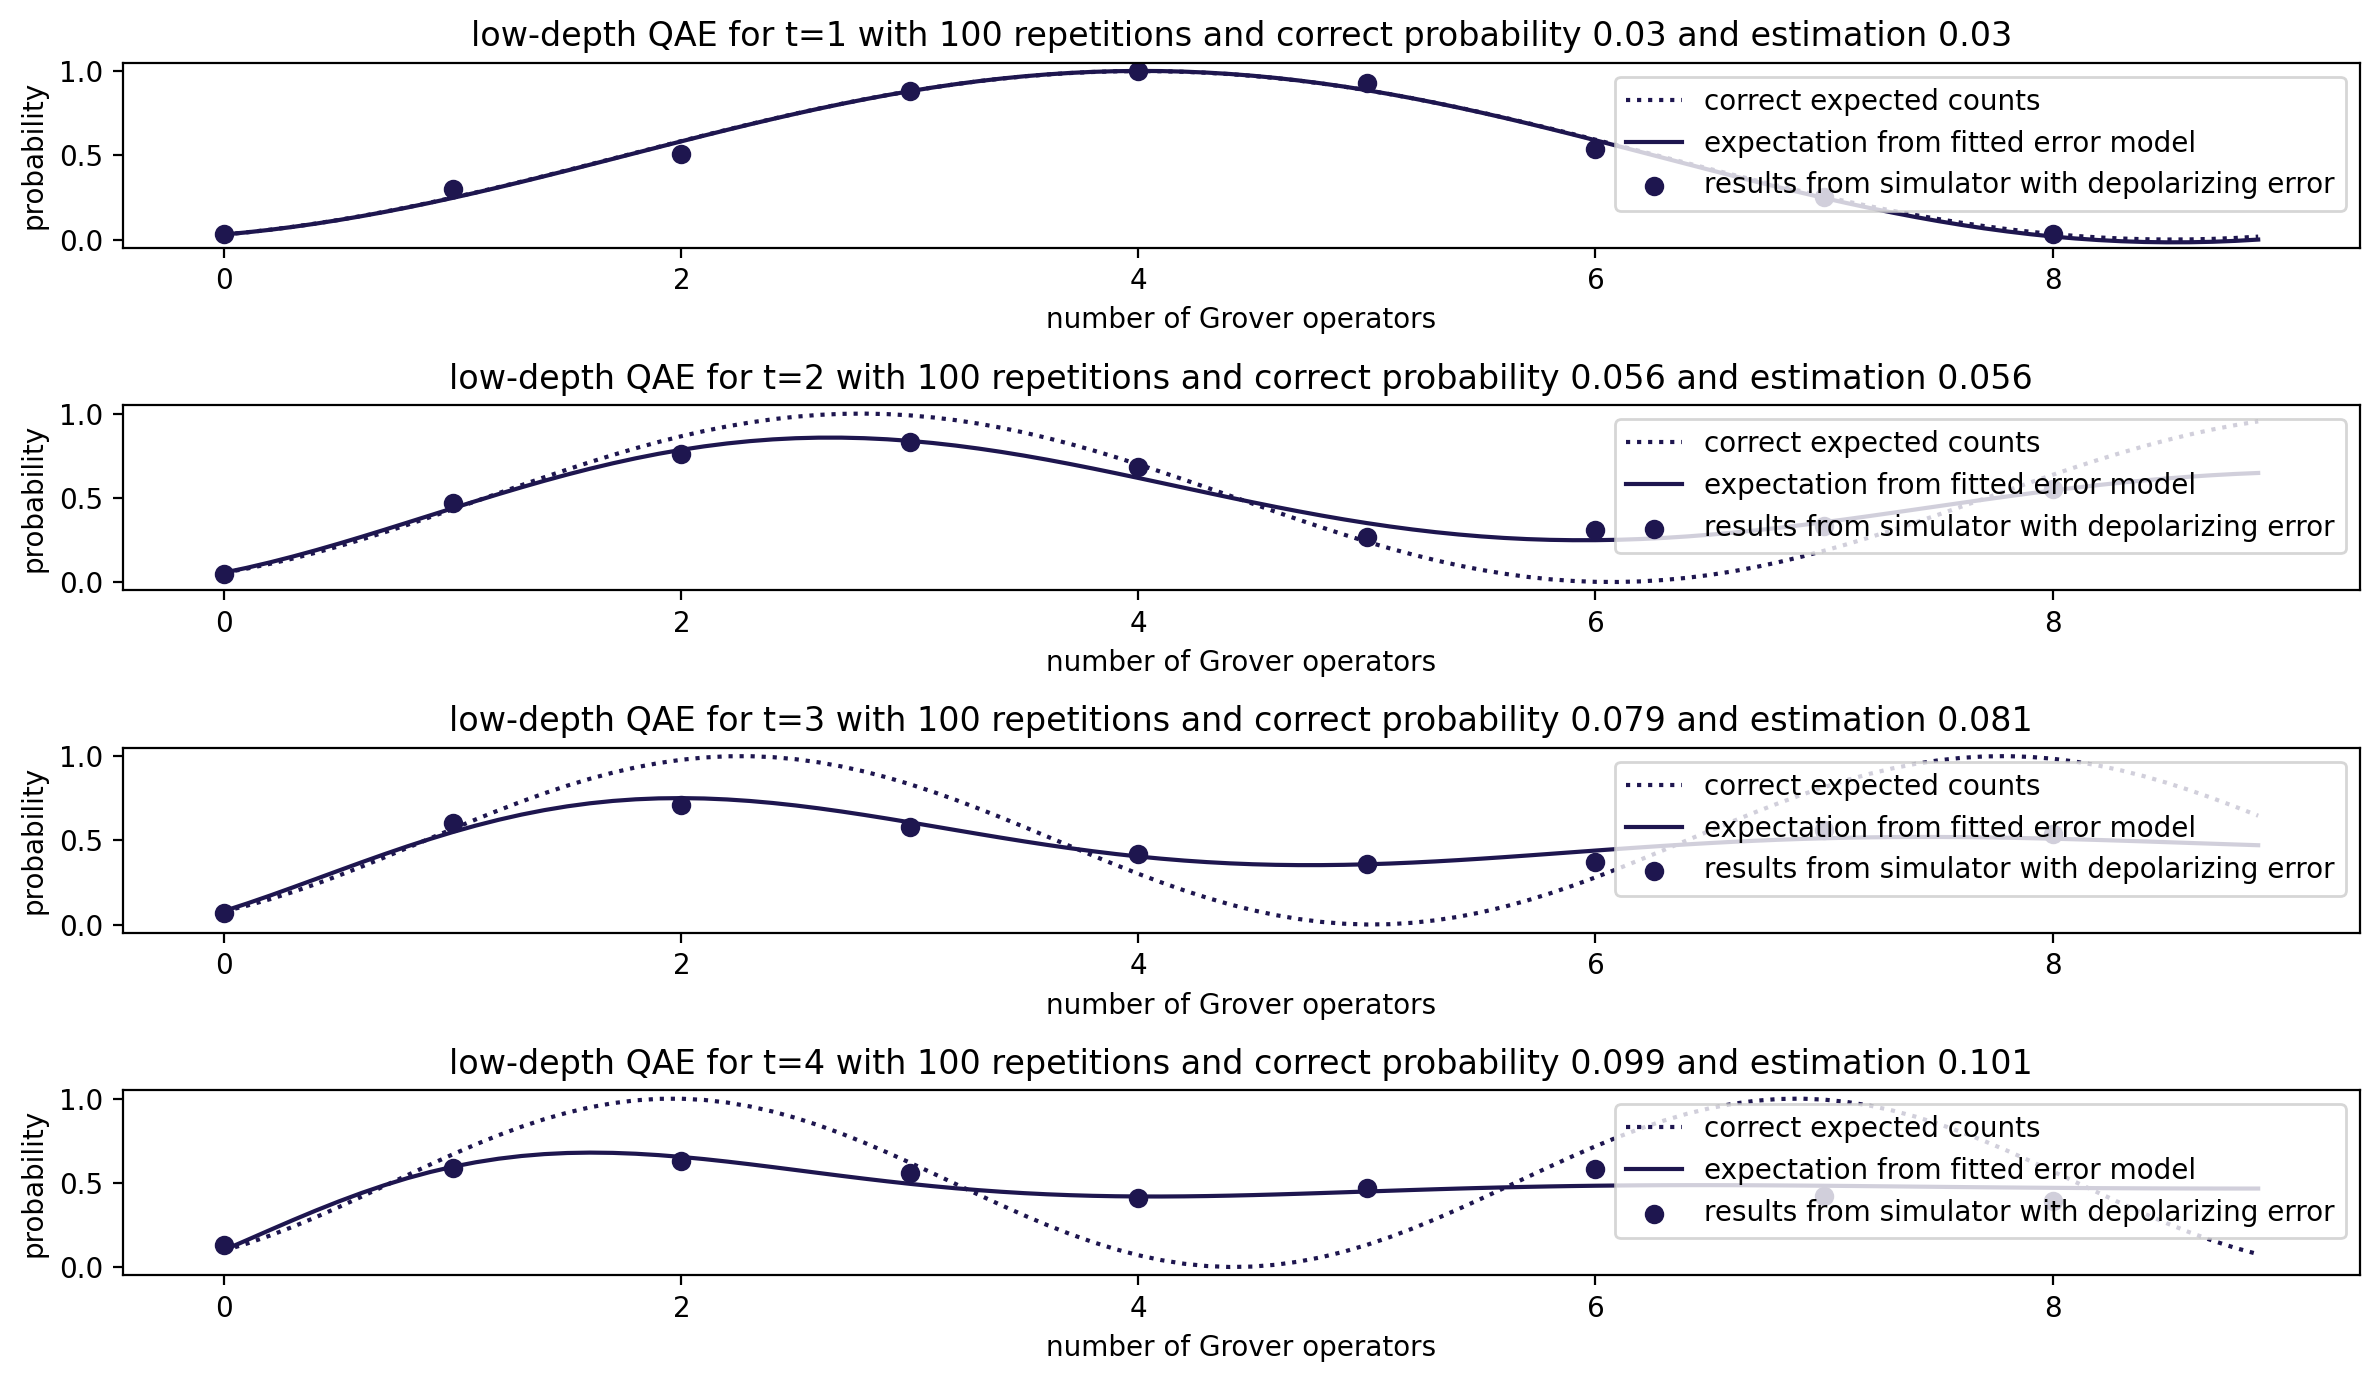

In [58]:
matplotlib.rcParams.update({'font.size': 10})
fig,axs=plt.subplots(4)

listYE=[ye_t1,ye_t2,ye_t3,ye_t4]
listYE2=[ye2_t1,ye2_t2,ye2_t3,ye2_t4]
listYE3=[ye3_t1,ye3_t2,ye3_t3,ye3_t4]

for i in range(4):
    axs[i].set_ylim([-0.05, 1.05])

for i in range(4):
    # The curves for the probabilities without error for the correct probabilities.
    axs[i].plot(xe_t,[y/n for y in listYE[i]],linestyle='dotted',color=jos_palette[3],label='correct expected counts')
    # The curves for the probabilities for the error model, which were found by gradient descent.
    axs[i].plot(xe2_t,[y/n for y in listYE2[i]],linestyle='solid',color=jos_palette[3],label='expectation from fitted error model')
    # The curves for the probabilities for the fits without error model, which were found by gradient descent.
    # axs[i].plot(xe3_t,[y/n for y in listYE3[i]],linestyle='dotted',color=jos_palette[1],label='expectation without model')
    # The results from the Qiskit simulator with a depolarizing error.
    axs[i].scatter(M_buffer[i],[y/n for y in R_buffer[i]],color=jos_palette[3],label='results from simulator with depolarizing error')
    axs[i].set_title('low-depth QAE for t='+str(i+1)+' with 100 repetitions and correct probability '+str(round(probs[i],3))+' and estimation '+str(round(resProbs[i],3)))
    axs[i].set_xlabel('number of Grover operators')
    axs[i].set_ylabel('probability')
    axs[i].legend(loc='upper right')

fig.tight_layout()